# Business Questions
## Does value investing portfolio outperform ASX200 index? 

In [1]:
# Objectives
# To construct a porfolio based on value investing critieria;
# To examine the relationship between value investing porfolio and ASX 200 index.

Value investing selection criteria
1. Current ratio >= 1.5
2. Debt to Equity ratio < 0.5
3. Earnings per share has been increasing over the past 5 years
4. Price to earnings ratio < 15
(P/E - based on the average earnings of the past threee years)
5. Price to Book value per share < 1.5

In [2]:
# Importing libraries & packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web
from datetime import date
# Winsorising 
from scipy.stats.mstats import winsorize

# for Transformation
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from scipy.stats import skew
from scipy import stats

# sklearn regressions and modelling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report

%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Importing data
df1 = pd.read_excel('finresults (1).xlsx')
df2 = pd.read_excel('finresults (2).xlsx')
df3 = pd.read_excel('finresults (3).xlsx')
df4 = pd.read_excel('advanced.xlsx')

In [5]:
# ASX 200 lists as at June 2020
df5 = pd.read_csv('20200601-asx200.csv', skiprows = 1)
df5 = df5[['Code','Company','Sector','Market Cap', 'Weight(%)']]

In [6]:
# Making a copy
df1a = df1.copy()
df2a = df2.copy()
df3a = df3.copy()
df4a = df4.copy()
df5a = df5.copy()

In [7]:
# writing a function to transform the dataset
def transforming(data, var):
    # Identifying str position
    data['new'] = data[var].str.find('-',start=1)+2
    data['new'] = data['new'].astype('int')
    
    # Creating a new column with boolean which contains str
    data["CF"] = data[var].str.contains("Annual Cash Flow")
    cf = data["CF"].sum()
    data["BS"] = data[var].str.contains("Annual Balance Sheet")
    bs = data["BS"].sum()
    data["PL"] = data[var].str.contains("Annual Profit and Loss")
    pl = data["PL"].sum()
    data["market"] = data[var].str.contains("Annual Ratio Analysis")
    market = data["market"].sum()
    
#     print(cf)
#     print(bs)
#     print(pl)
#     print(market)
    
    # Renaming the values
    if cf>0: 
        word_count_cf = int(data.loc[data["CF"]==1, 'new'].mean())
        data.loc[data['CF']==True, var] = data.Item.str.slice(word_count_cf)
#         print(word_count_cf)
    if bs>0: 
        word_count_bs = int(data.loc[data["BS"]==1, 'new'].mean())
        data.loc[data['BS']==True, var] = data.Item.str.slice(word_count_bs)
#         print(word_count_bs)
    if pl>0:
        word_count_pl = int(data.loc[data["PL"]==1, 'new'].mean())
        data.loc[data['PL']==True, var] = data.Item.str.slice(word_count_pl)
#         print(word_count_pl)
    if market>0:
        word_count_market = int(data.loc[data["market"]==1, 'new'].mean())
        data.loc[data['market']==True, var] = data.Item.str.slice(word_count_market)
#         print(word_count_market)



In [8]:
# transforming the data including BS, PL, CF, market information
transforming(df1a, 'Item')
transforming(df2a, 'Item')
transforming(df3a, 'Item')

In [9]:
# saving each file under different year
# df1a
for i in range(2010,2021):
    locals()['df1a_{0}'.format(i)] = df1a.pivot(index='ASX Code', columns='Item', values=str(i))
    locals()['df1a_{0}'.format(i)]['year'] = i
#     print('df1a_'+str(i))
# df2a
for i in range(2010,2021):
    locals()['df2a_{0}'.format(i)] = df2a.pivot(index='ASX Code', columns='Item', values=str(i))
    locals()['df2a_{0}'.format(i)]['year'] = i
#     print('df2a_'+str(i))
# df3a
for i in range(2010,2021):
    locals()['df3a_{0}'.format(i)] = df3a.pivot(index='ASX Code', columns='Item', values=str(i))
    locals()['df3a_{0}'.format(i)]['year'] = i
#     print('df3a_'+str(i))


In [10]:
# appeding all the files
#df1a 
balance_sheet = df1a_2010.append([df1a_2011,
                                  df1a_2012,
                                  df1a_2013,
                                  df1a_2014,
                                  df1a_2015,
                                  df1a_2016,
                                  df1a_2017,
                                  df1a_2018,
                                  df1a_2019,
                                  df1a_2020])
#df2a 
income_statement = df2a_2010.append([df2a_2011,
                                  df2a_2012,
                                  df2a_2013,
                                  df2a_2014,
                                  df2a_2015,
                                  df2a_2016,
                                  df2a_2017,
                                  df2a_2018,
                                  df2a_2019,
                                  df2a_2020])
#df3a 
cash_flow = df3a_2010.append([df3a_2011,
                              df3a_2012,
                              df3a_2013,
                              df3a_2014,
                              df3a_2015,
                              df3a_2016,
                              df3a_2017,
                              df3a_2018,
                              df3a_2019,
                              df3a_2020])

# Merging data

In [11]:
financial = cash_flow.merge(balance_sheet, how='left', on=['ASX Code','year'])
financial = financial.merge(income_statement, how='left', on=['ASX Code','year'])
financial = financial.merge(df4a, how='left', on=['ASX Code'])

In [12]:
# only keeping ASX 200 firms based on June 2021 list
fin_asx200 = financial.merge(df5a, left_on='ASX Code', right_on='Code', 
                            validate="m:1")

In [13]:
keeping_list = ['ASX Code','Year End Share Price ($)','year',
               'Total Curr. Liabilities','Total Current Assets',
               'Total Equity','Total Liabilities',
               'Reported NPAT After Abnorma','Weighted Average Number of',
               'Company Name','GICS Sector','GICS Industry Group',
               'GICS Industry','Market Cap.($)']

In [14]:
fin_asx200_clean = fin_asx200[keeping_list]
fin_asx200_clean.head(2)

,ASX Code,Year End Share Price ($),year,Total Curr. Liabilities,Total Current Assets,Total Equity,Total Liabilities,Reported NPAT After Abnorma,Weighted Average Number of,Company Name,GICS Sector,GICS Industry Group,GICS Industry,Market Cap.($)
0,A2M,,2010,,,,,,,The a2 Milk Company Limited,Consumer Staples,"Food, Beverage & Tobacco",Food Products,
1,A2M,,2011,,,,,,,The a2 Milk Company Limited,Consumer Staples,"Food, Beverage & Tobacco",Food Products,


In [15]:
fin_asx200_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2178 entries, 0 to 2177
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   ASX Code                     2178 non-null   object
 1   Year End Share Price ($)     2178 non-null   object
 2   year                         2178 non-null   int64 
 3   Total Curr. Liabilities      2178 non-null   object
 4   Total Current Assets         2178 non-null   object
 5   Total Equity                 2178 non-null   object
 6   Total Liabilities            2178 non-null   object
 7   Reported NPAT After Abnorma  2178 non-null   object
 8   Weighted Average Number of   2178 non-null   object
 9   Company Name                 2178 non-null   object
 10  GICS Sector                  2178 non-null   object
 11  GICS Industry Group          2178 non-null   object
 12  GICS Industry                2178 non-null   object
 13  Market Cap.($)               2178

In [16]:
# converting to numeric
convert_numeric = ['Year End Share Price ($)','Total Curr. Liabilities',
                  'Total Current Assets','Total Equity','Total Liabilities',
                  'Reported NPAT After Abnorma','Weighted Average Number of',
                  'Market Cap.($)']
for i in fin_asx200_clean[convert_numeric]:
    fin_asx200_clean[i] = pd.to_numeric(fin_asx200_clean[i], 
                                        errors='coerce',
                                       downcast='float')
fin_asx200_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2178 entries, 0 to 2177
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ASX Code                     2178 non-null   object 
 1   Year End Share Price ($)     1945 non-null   float32
 2   year                         2178 non-null   int64  
 3   Total Curr. Liabilities      1910 non-null   float32
 4   Total Current Assets         1911 non-null   float32
 5   Total Equity                 1983 non-null   float32
 6   Total Liabilities            1983 non-null   float32
 7   Reported NPAT After Abnorma  1983 non-null   float32
 8   Weighted Average Number of   1983 non-null   float32
 9   Company Name                 2178 non-null   object 
 10  GICS Sector                  2178 non-null   object 
 11  GICS Industry Group          2178 non-null   object 
 12  GICS Industry                2178 non-null   object 
 13  Market Cap.($)    

<ipython-input-16-83457ecfa6f1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fin_asx200_clean[i] = pd.to_numeric(fin_asx200_clean[i],


In [17]:
# dealing with missing values
# I will drop observations that is missing
missing_val_1 = fin_asx200_clean['Total Curr. Liabilities'].isna()
missing_val_2 = fin_asx200_clean['Year End Share Price ($)'].isna()

fin_asx200_clean = fin_asx200_clean.loc[missing_val_1==False]
fin_asx200_clean = fin_asx200_clean.loc[missing_val_2==False]

fin_asx200_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1873 entries, 5 to 2177
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ASX Code                     1873 non-null   object 
 1   Year End Share Price ($)     1873 non-null   float32
 2   year                         1873 non-null   int64  
 3   Total Curr. Liabilities      1873 non-null   float32
 4   Total Current Assets         1873 non-null   float32
 5   Total Equity                 1873 non-null   float32
 6   Total Liabilities            1873 non-null   float32
 7   Reported NPAT After Abnorma  1873 non-null   float32
 8   Weighted Average Number of   1873 non-null   float32
 9   Company Name                 1873 non-null   object 
 10  GICS Sector                  1873 non-null   object 
 11  GICS Industry Group          1873 non-null   object 
 12  GICS Industry                1873 non-null   object 
 13  Market Cap.($)    

In [18]:
fin_asx200_clean = fin_asx200_clean.set_index('year')
fin_asx200_clean.head(2)

,ASX Code,Year End Share Price ($),Total Curr. Liabilities,Total Current Assets,Total Equity,Total Liabilities,Reported NPAT After Abnorma,Weighted Average Number of,Company Name,GICS Sector,GICS Industry Group,GICS Industry,Market Cap.($)
year,,,,,,,,,,,,,
2015,A2M,0.64,25634850.0,53597484.0,51911632.0,26773508.0,-1851425.0,633337024.0,The a2 Milk Company Limited,Consumer Staples,"Food, Beverage & Tobacco",Food Products,4.053293e+08
2016,A2M,1.75,73227192.0,173918384.0,126873864.0,73480792.0,29017064.0,686870016.0,The a2 Milk Company Limited,Consumer Staples,"Food, Beverage & Tobacco",Food Products,1.246000e+09


# Financial ratio calculation

In [19]:
fin_asx200_clean.describe()

,Year End Share Price ($),Total Curr. Liabilities,Total Current Assets,Total Equity,Total Liabilities,Reported NPAT After Abnorma,Weighted Average Number of,Market Cap.($)
count,1873.000000,1.873000e+03,1.873000e+03,1.873000e+03,1.873000e+03,1.873000e+03,1.873000e+03,1.873000e+03
mean,11.037590,2.310909e+09,2.501040e+09,3.409519e+09,5.612683e+09,3.422404e+08,8.440113e+08,6.958384e+09
std,19.813421,9.915673e+09,9.565482e+09,8.182688e+09,1.837882e+10,1.379706e+09,1.276923e+09,1.821695e+10
min,0.010000,6.949100e+04,2.069260e+05,-9.805860e+08,6.949100e+04,-8.358470e+09,1.655617e+07,7.766500e+05
25%,2.300000,7.932100e+07,1.424130e+08,3.143880e+08,2.231600e+08,2.226500e+07,1.968778e+08,9.348762e+08
50%,4.870000,2.901466e+08,4.569000e+08,1.210722e+09,8.595000e+08,9.502200e+07,4.529195e+08,2.258218e+09
75%,11.810000,1.051000e+09,1.525938e+09,3.174285e+09,3.280255e+09,2.920000e+08,9.587785e+08,6.483479e+09
max,287.000000,1.447210e+11,1.279160e+11,9.185547e+10,2.340180e+11,2.229817e+10,1.241800e+10,2.331286e+11


In [21]:
# There are negative values for Total Equity
# I will drop those company with negative total equity
fin_asx200_clean.loc[fin_asx200_clean['Total Equity']<0.1]['ASX Code'].value_counts()

JHX    7
ALX    3
SYD    1
Name: ASX Code, dtype: int64

In [25]:
drop_list = ['JHX','ALX','SYD']
for i in range(len(drop_list)):
    fin_asx200_clean = fin_asx200_clean.loc[fin_asx200_clean['ASX Code'] != drop_list[i]]

In [29]:
# Financial ratios
# current ratio
fin_asx200_clean['current_ratio'] = fin_asx200_clean['Total Current Assets']/fin_asx200_clean['Total Curr. Liabilities']
# Debt to equity
fin_asx200_clean['DE'] = fin_asx200_clean['Total Liabilities']/fin_asx200_clean['Total Equity']
# Earnings per share
fin_asx200_clean['EPS'] = fin_asx200_clean['Reported NPAT After Abnorma']/fin_asx200_clean['Weighted Average Number of']
# Price to EPS
fin_asx200_clean['PE'] = fin_asx200_clean['Year End Share Price ($)']/fin_asx200_clean['EPS']
# Price to Book value per share
fin_asx200_clean['BV'] = (fin_asx200_clean['Total Equity']/fin_asx200_clean['Weighted Average Number of'])
fin_asx200_clean['PB'] = fin_asx200_clean['Year End Share Price ($)'] / fin_asx200_clean['BV']
# dummy for loss making firms
fin_asx200_clean['d_loss'] = fin_asx200_clean['Reported NPAT After Abnorma'] < 0
# ROE
shift one cell up and take the average
fin_asx200_clean['ROE'] = fin_asx200_clean['Reported NPAT After Abnorma'] / fin_asx200_clean['Total Equity']

# ROA
fin_asx200_clean['ROA']

# PM
fin_asx200_clean['PM']

# % change in EPS
fin_asx200_clean['EPS_change']
eps - epst-1/eps

# percentage of cash?? 
# cashflow???


In [30]:
# returns on share price
fin_asx200_clean['share_price_t-1'] = fin_asx200_clean.groupby('ASX Code')['Year End Share Price ($)'].shift(1)
fin_asx200_clean['return'] = (fin_asx200_clean['Year End Share Price ($)']/fin_asx200_clean['share_price_t-1']) - 1
fin_asx200_clean['d_positive_ret'] = fin_asx200_clean['return']>=0

In [44]:
fin_asx200_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1654 entries, 2016 to 2020
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ASX Code                     1654 non-null   object 
 1   Year End Share Price ($)     1654 non-null   float32
 2   Total Curr. Liabilities      1654 non-null   float32
 3   Total Current Assets         1654 non-null   float32
 4   Total Equity                 1654 non-null   float32
 5   Total Liabilities            1654 non-null   float32
 6   Reported NPAT After Abnorma  1654 non-null   float32
 7   Weighted Average Number of   1654 non-null   float32
 8   Company Name                 1654 non-null   object 
 9   GICS Sector                  1654 non-null   object 
 10  GICS Industry Group          1654 non-null   object 
 11  GICS Industry                1654 non-null   object 
 12  Market Cap.($)               1654 non-null   float32
 13  current_ratio  

In [45]:
fin_asx200.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2178 entries, 0 to 2177
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ASX Code                     2178 non-null   object 
 1   Market Cap.($)               2178 non-null   object 
 2   Net Financing Cash Flow      2178 non-null   object 
 3   Net Investing Cash Flow      2178 non-null   object 
 4   Net Operating Cash Flow_x    2178 non-null   object 
 5   Year End Share Price ($)     2178 non-null   object 
 6   year                         2178 non-null   int64  
 7   CA Cash                      2178 non-null   object 
 8   CA Inventories               2178 non-null   object 
 9   CL Short-Term Debt           2178 non-null   object 
 10  NCL Long-Term Debt           2178 non-null   object 
 11  Net Operating Cash Flow_y    2178 non-null   object 
 12  Total Assets                 2178 non-null   object 
 13  Total Curr. Liabil

# Value investing criteria

In [31]:
# value investing criteria
# 1. Current ratio >= 1.5
fin_asx200_clean['criteria_1'] = fin_asx200_clean['current_ratio']>=1.5
# 2. Debt to Equity ratio < 0.5
fin_asx200_clean['criteria_2'] = fin_asx200_clean['DE']<0.5
# 3. Earnings per share has been increasing over the past 3 years
# increase from the previous year
fin_asx200_clean['EPS_up_t-1'] = fin_asx200_clean['EPS']>fin_asx200_clean.groupby('ASX Code')['EPS'].shift(1)
fin_asx200_clean['EPS_up_t-2'] = fin_asx200_clean['EPS']>fin_asx200_clean.groupby('ASX Code')['EPS'].shift(2)
# fin_asx200_clean['EPS_up_t-3'] = fin_asx200_clean['EPS']>fin_asx200_clean.groupby('ASX Code')['EPS'].shift(3)
# fin_asx200_clean['EPS_up_t-4'] = fin_asx200_clean['EPS']>fin_asx200_clean.groupby('ASX Code')['EPS'].shift(4)
fin_asx200_clean['criteria_3'] = ((fin_asx200_clean['EPS_up_t-1']==True) &
                                 (fin_asx200_clean['EPS_up_t-2']==True) )
# 4. Price to earnings ratio < 15
# (P/E - based on the average earnings of the past threee years)
fin_asx200_clean['EPS_t-1'] = fin_asx200_clean.groupby('ASX Code')['EPS'].shift(1) 
fin_asx200_clean['EPS_t-2'] = fin_asx200_clean.groupby('ASX Code')['EPS'].shift(2) 
fin_asx200_clean['EPS_3yr'] = (fin_asx200_clean['EPS'] + fin_asx200_clean['EPS_t-1'] + fin_asx200_clean['EPS_t-2'])/3
fin_asx200_clean['PE_EPS_3yr'] = (fin_asx200_clean['PE']/fin_asx200_clean['EPS_3yr'])
fin_asx200_clean['criteria_4'] = (fin_asx200_clean['PE_EPS_3yr'] < 15) & (fin_asx200_clean['PE_EPS_3yr']>= 0)

# 5. Price to Book value per share < 1.5
fin_asx200_clean['criteria_5'] = fin_asx200_clean['PB']<1.5


In [32]:
fin_asx200_clean['criteria_1'].count()

1842

In [33]:
fin_asx200_clean[['criteria_1','criteria_2','criteria_3','criteria_4','criteria_5']].sum()

criteria_1    972
criteria_2    528
criteria_3    704
criteria_4    235
criteria_5    713
dtype: int64

In [34]:
selected_firms = fin_asx200_clean.loc[(fin_asx200_clean['criteria_1']==True) &
                    (fin_asx200_clean['criteria_2']==True) &
                    (fin_asx200_clean['criteria_3']==True) &
                    (fin_asx200_clean['criteria_4']==True) &
                    (fin_asx200_clean['criteria_5']==True)]


In [35]:
selected_firms.index.value_counts().sort_index()

2013    2
2014    1
2017    3
2018    1
2020    1
Name: year, dtype: int64

In [36]:
selected_firms.loc[selected_firms.index==2015]['ASX Code']

Series([], Name: ASX Code, dtype: object)

In [37]:
selected_firms.loc[selected_firms.index==2015]['GICS Sector'].value_counts()

Series([], Name: GICS Sector, dtype: int64)

In [38]:
selected_firms_lists = {"year2012":['COE'],
                        "year2013":['ORE','PMV'],
                        "year2014":['IGO','SGM'],
                        "year2015":['EVN','OZL','SAR','SGM','SSM'],
                        "year2016":['SLR'],
                        "year2017":['BKW','BPT','JHG','S32','SOL'],
                        "year2018":['WPL']}
selected_firms_lists

{'year2012': ['COE'],
 'year2013': ['ORE', 'PMV'],
 'year2014': ['IGO', 'SGM'],
 'year2015': ['EVN', 'OZL', 'SAR', 'SGM', 'SSM'],
 'year2016': ['SLR'],
 'year2017': ['BKW', 'BPT', 'JHG', 'S32', 'SOL'],
 'year2018': ['WPL']}

### Excluding missing value due to return calculation based on t-1

In [39]:
# fin_asx200_clean that are not missing
fin_asx200_clean = fin_asx200_clean[~fin_asx200_clean['return'].isna()]

In [40]:
fin_asx200_clean.describe().T
# [['current_ratio','DE','EPS','PE','PB']]

,count,mean,std,min,25%,50%,75%,max
Year End Share Price ($),1654.0,1.155174e+01,2.066720e+01,1.000000e-02,2.450000e+00,5.050000e+00,1.210750e+01,2.870000e+02
Total Curr. Liabilities,1654.0,2.376627e+09,9.884148e+09,6.949100e+04,8.772300e+07,3.030090e+08,1.107033e+09,1.447210e+11
Total Current Assets,1654.0,2.508854e+09,9.327282e+09,2.069260e+05,1.606148e+08,4.747700e+08,1.560244e+09,1.279160e+11
Total Equity,1654.0,3.540613e+09,8.374705e+09,1.904347e+06,3.434893e+08,1.273649e+09,3.249598e+09,9.185547e+10
Total Liabilities,1654.0,5.807387e+09,1.895651e+10,6.949100e+04,2.379762e+08,8.806000e+08,3.379919e+09,2.340180e+11
Reported NPAT After Abnorma,1654.0,3.448381e+08,1.365478e+09,-8.358470e+09,2.641100e+07,1.027275e+08,2.956245e+08,2.229817e+10
Weighted Average Number of,1654.0,8.488611e+08,1.284959e+09,1.673340e+07,1.999795e+08,4.599943e+08,9.608678e+08,1.241800e+10
Market Cap.($),1654.0,7.108899e+09,1.811907e+10,7.766500e+05,9.978385e+08,2.338007e+09,6.622493e+09,2.331286e+11
current_ratio,1654.0,2.270506e+00,2.711765e+00,3.356424e-02,1.049724e+00,1.560866e+00,2.372651e+00,4.257083e+01
DE,1654.0,1.288083e+00,2.011384e+00,2.726586e-02,4.626982e-01,7.959298e-01,1.304093e+00,2.866734e+01


# Done with cleaning the data

# Ready to use the data but requires transformation

In [43]:
fin_asx200_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1654 entries, 2016 to 2020
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ASX Code                     1654 non-null   object 
 1   Year End Share Price ($)     1654 non-null   float32
 2   Total Curr. Liabilities      1654 non-null   float32
 3   Total Current Assets         1654 non-null   float32
 4   Total Equity                 1654 non-null   float32
 5   Total Liabilities            1654 non-null   float32
 6   Reported NPAT After Abnorma  1654 non-null   float32
 7   Weighted Average Number of   1654 non-null   float32
 8   Company Name                 1654 non-null   object 
 9   GICS Sector                  1654 non-null   object 
 10  GICS Industry Group          1654 non-null   object 
 11  GICS Industry                1654 non-null   object 
 12  Market Cap.($)               1654 non-null   float32
 13  current_ratio  

In [ ]:
features = 

In [ ]:
target = 

# Winsorize at top and bottom 1%

In [41]:
for name in fin_asx200_clean[['return','current_ratio','DE','EPS','PE','PB','BV']]:
    fin_asx200_clean[name+"_w1"] = winsorize(fin_asx200_clean[name], 
                                           limits = [0.01,0.01])

In [33]:
# based on time
mean_return = fin_asx200_clean.groupby('year')['return_w1'].mean()
mean_current_ratio = fin_asx200_clean.groupby('year')['current_ratio_w1'].mean()
mean_DE = fin_asx200_clean.groupby('year')['DE_w1'].mean()
mean_EPS = fin_asx200_clean.groupby('year')['EPS_w1'].mean()
mean_PE = fin_asx200_clean.groupby('year')['PE_w1'].mean()
mean_PB = fin_asx200_clean.groupby('year')['PB_w1'].mean()
mean_BV = fin_asx200_clean.groupby('year')['BV_w1'].mean()


# Transformation (Log, Box-Cox, Quantile)

In [34]:
# needs transformation
# log or power or quant

In [35]:
power = PowerTransformer()
quant = QuantileTransformer(output_distribution='normal')

In [36]:
for name in fin_asx200_clean[['return_w1','current_ratio_w1','DE_w1','EPS_w1','PE_w1','PB_w1','BV_w1']]:
    fin_asx200_clean[name+'_log'] = np.log(fin_asx200_clean[name]+1)
    fin_asx200_clean[name+'_power'] = power.fit_transform(fin_asx200_clean[[name]])
    fin_asx200_clean[name+'_quant'] = quant.fit_transform(fin_asx200_clean[[name]])


/Users/jinyang/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jinyang/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jinyang/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


# Summary statistic

In [37]:
fin_asx200_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
Year End Share Price ($),1654.0,1.155174e+01,2.066720e+01,1.000000e-02,2.450000e+00,5.050000e+00,1.210750e+01,2.870000e+02
Total Curr. Liabilities,1654.0,2.376627e+09,9.884148e+09,6.949100e+04,8.772300e+07,3.030090e+08,1.107033e+09,1.447210e+11
Total Current Assets,1654.0,2.508854e+09,9.327282e+09,2.069260e+05,1.606148e+08,4.747700e+08,1.560244e+09,1.279160e+11
Total Equity,1654.0,3.540613e+09,8.374705e+09,1.904347e+06,3.434893e+08,1.273649e+09,3.249598e+09,9.185547e+10
Total Liabilities,1654.0,5.807387e+09,1.895651e+10,6.949100e+04,2.379762e+08,8.806000e+08,3.379919e+09,2.340180e+11
Reported NPAT After Abnorma,1654.0,3.448381e+08,1.365478e+09,-8.358470e+09,2.641100e+07,1.027275e+08,2.956245e+08,2.229817e+10
Weighted Average Number of,1654.0,8.488611e+08,1.284959e+09,1.673340e+07,1.999795e+08,4.599943e+08,9.608678e+08,1.241800e+10
Market Cap.($),1654.0,7.108899e+09,1.811907e+10,7.766500e+05,9.978385e+08,2.338007e+09,6.622493e+09,2.331286e+11
current_ratio,1654.0,2.270506e+00,2.711765e+00,3.356424e-02,1.049724e+00,1.560866e+00,2.372651e+00,4.257083e+01
DE,1654.0,1.288083e+00,2.011384e+00,2.726586e-02,4.626982e-01,7.959298e-01,1.304093e+00,2.866734e+01


# Distribution (Histogram)

### Raw variables

In [38]:
num_bins = 20

Text(0.5, 1.0, 'PB')

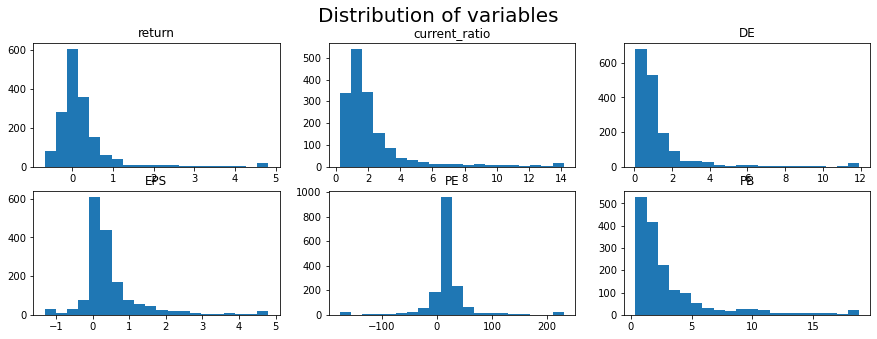

In [39]:
fig, axs = subplots(2,3, figsize=(15,5))
plt.suptitle("Distribution of variables", size=20)
axs[0,0].hist(fin_asx200_clean['return_w1'], bins=num_bins)
axs[0,0].set_title("return")

axs[0,1].hist(fin_asx200_clean['current_ratio_w1'], bins=num_bins)
axs[0,1].set_title("current_ratio")

axs[0,2].hist(fin_asx200_clean['DE_w1'], bins=num_bins)
axs[0,2].set_title("DE")

axs[1,0].hist(fin_asx200_clean['EPS_w1'], bins=num_bins)
axs[1,0].set_title("EPS")

axs[1,1].hist(fin_asx200_clean['PE_w1'], bins=num_bins)
axs[1,1].set_title("PE")

axs[1,2].hist(fin_asx200_clean['PB_w1'], bins=num_bins)
axs[1,2].set_title("PB")


### Transformed variables

#### 1. return

Text(0.5, 1.0, 'Quantile')

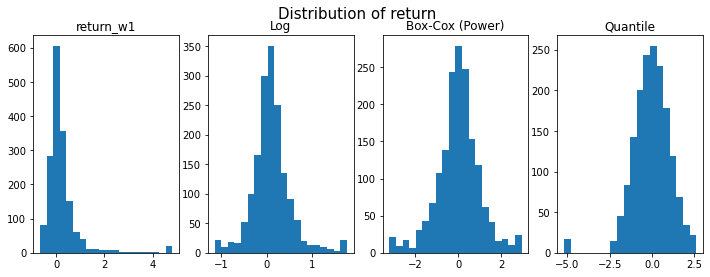

In [40]:
var_name = 'return_w1'

fig, (ax1, ax2, ax3, ax4) = subplots(1,4, figsize=(12,4))
plt.suptitle("Distribution of return", size=15)

ax1.hist(fin_asx200_clean[var_name], bins=num_bins)
ax1.set_title(var_name)

ax2.hist(fin_asx200_clean[var_name+'_log'], bins=num_bins)
ax2.set_title("Log")

ax3.hist(fin_asx200_clean[var_name+'_power'], bins=num_bins)
ax3.set_title("Box-Cox (Power)")

ax4.hist(fin_asx200_clean[var_name+'_quant'], bins=num_bins)
ax4.set_title("Quantile")


#### 2. current ratio

Text(0.5, 1.0, 'Quantile')

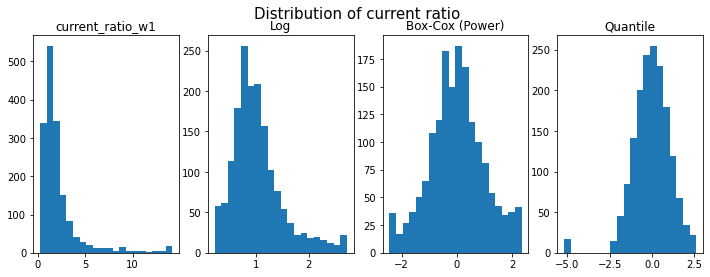

In [41]:
var_name = 'current_ratio_w1'

fig, (ax1, ax2, ax3, ax4) = subplots(1,4, figsize=(12,4))
plt.suptitle("Distribution of current ratio", size=15)

ax1.hist(fin_asx200_clean[var_name], bins=num_bins)
ax1.set_title(var_name)

ax2.hist(fin_asx200_clean[var_name+'_log'], bins=num_bins)
ax2.set_title("Log")

ax3.hist(fin_asx200_clean[var_name+'_power'], bins=num_bins)
ax3.set_title("Box-Cox (Power)")

ax4.hist(fin_asx200_clean[var_name+'_quant'], bins=num_bins)
ax4.set_title("Quantile")


#### 3. DE

Text(0.5, 1.0, 'Quantile')

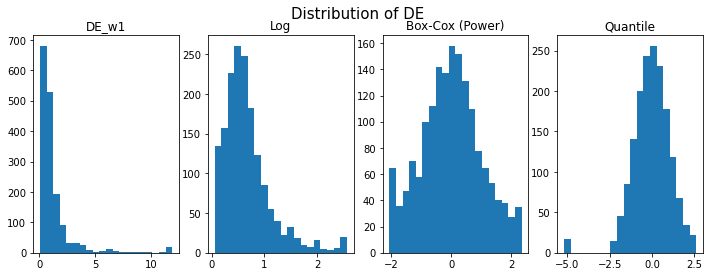

In [42]:
var_name = 'DE_w1'

fig, (ax1, ax2, ax3, ax4) = subplots(1,4, figsize=(12,4))
plt.suptitle("Distribution of DE", size=15)

ax1.hist(fin_asx200_clean[var_name], bins=num_bins)
ax1.set_title(var_name)

ax2.hist(fin_asx200_clean[var_name+'_log'], bins=num_bins)
ax2.set_title("Log")

ax3.hist(fin_asx200_clean[var_name+'_power'], bins=num_bins)
ax3.set_title("Box-Cox (Power)")

ax4.hist(fin_asx200_clean[var_name+'_quant'], bins=num_bins)
ax4.set_title("Quantile")


#### 4. EPS

Text(0.5, 1.0, 'Quantile')

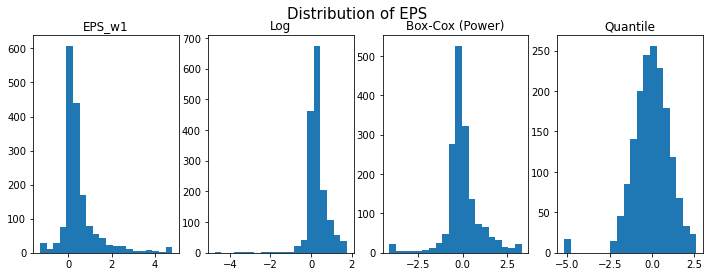

In [43]:
var_name = 'EPS_w1'

fig, (ax1, ax2, ax3, ax4) = subplots(1,4, figsize=(12,4))
plt.suptitle("Distribution of EPS", size=15)

ax1.hist(fin_asx200_clean[var_name], bins=num_bins)
ax1.set_title(var_name)

ax2.hist(fin_asx200_clean[var_name+'_log'], bins=num_bins)
ax2.set_title("Log")

ax3.hist(fin_asx200_clean[var_name+'_power'], bins=num_bins)
ax3.set_title("Box-Cox (Power)")

ax4.hist(fin_asx200_clean[var_name+'_quant'], bins=num_bins)
ax4.set_title("Quantile")


#### 5. PE

Text(0.5, 1.0, 'Quantile')

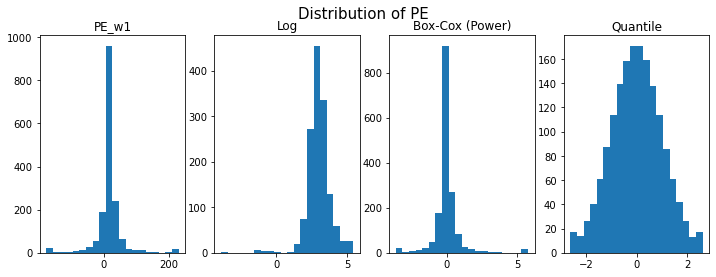

In [44]:
var_name = 'PE_w1'

fig, (ax1, ax2, ax3, ax4) = subplots(1,4, figsize=(12,4))
plt.suptitle("Distribution of PE", size=15)

ax1.hist(fin_asx200_clean[var_name], bins=num_bins)
ax1.set_title(var_name)

ax2.hist(fin_asx200_clean[var_name+'_log'], bins=num_bins)
ax2.set_title("Log")

ax3.hist(fin_asx200_clean[var_name+'_power'], bins=num_bins)
ax3.set_title("Box-Cox (Power)")

ax4.hist(fin_asx200_clean[var_name+'_quant'], bins=num_bins)
ax4.set_title("Quantile")


#### 6. PB

Text(0.5, 1.0, 'Quantile')

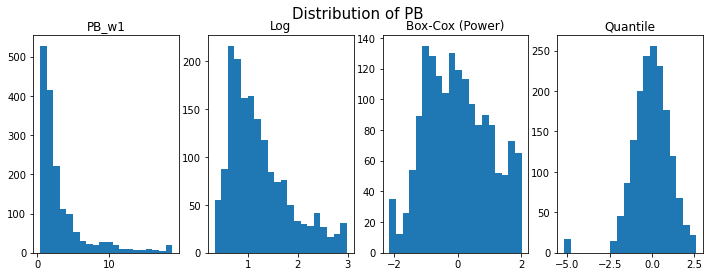

In [45]:
var_name = 'PB_w1'

fig, (ax1, ax2, ax3, ax4) = subplots(1,4, figsize=(12,4))
plt.suptitle("Distribution of PB", size=15)

ax1.hist(fin_asx200_clean[var_name], bins=num_bins)
ax1.set_title(var_name)

ax2.hist(fin_asx200_clean[var_name+'_log'], bins=num_bins)
ax2.set_title("Log")

ax3.hist(fin_asx200_clean[var_name+'_power'], bins=num_bins)
ax3.set_title("Box-Cox (Power)")

ax4.hist(fin_asx200_clean[var_name+'_quant'], bins=num_bins)
ax4.set_title("Quantile")


In [46]:
fin_asx200_clean

,ASX Code,Year End Share Price ($),Total Curr. Liabilities,Total Current Assets,Total Equity,Total Liabilities,Reported NPAT After Abnorma,Weighted Average Number of,Company Name,GICS Sector,...,EPS_w1_quant,PE_w1_log,PE_w1_power,PE_w1_quant,PB_w1_log,PB_w1_power,PB_w1_quant,BV_w1_log,BV_w1_power,BV_w1_quant
year,,,,,,,,,,,,,,,,,,,,,
2016,A2M,1.750000,73227192.0,1.739184e+08,1.268739e+08,73480792.0,29017064.0,686870016.0,The a2 Milk Company Limited,Consumer Staples,...,-0.841962,3.747730,0.572448,1.231386,2.348911,1.620622,1.433402,0.169501,-1.777894,-1.761030
2017,A2M,3.760000,97474288.0,2.459886e+08,2.299829e+08,97569520.0,86329520.0,716046976.0,The a2 Milk Company Limited,Consumer Staples,...,-0.491271,3.471555,0.305621,0.937578,2.542128,1.760272,1.703115,0.278528,-1.574281,-1.543609
2018,A2M,10.520000,152938640.0,4.641493e+08,5.096845e+08,153048704.0,179477216.0,724684992.0,The a2 Milk Company Limited,Consumer Staples,...,-0.009752,3.772236,0.600067,1.256646,2.769939,1.900340,1.937340,0.532578,-1.125142,-1.066283
2019,A2M,13.850000,196319056.0,6.458602e+08,7.530625e+08,196536032.0,275034400.0,733145024.0,The a2 Milk Company Limited,Consumer Staples,...,0.339233,3.635458,0.454598,1.117595,2.673023,1.843739,1.840016,0.706639,-0.836782,-0.824139
2020,A2M,18.660000,285365792.0,1.054420e+09,1.059574e+09,298285536.0,360494240.0,736467008.0,The a2 Milk Company Limited,Consumer Staples,...,0.532286,3.666665,0.485977,1.160886,2.636899,1.821537,1.790311,0.891476,-0.546776,-0.497908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,XRO,13.950000,42138736.0,1.905225e+08,2.514315e+08,44154952.0,-74291888.0,136428992.0,Xero Limited,Information Technology,...,-1.901611,NaN,-0.970972,-1.598271,2.148197,1.451793,1.258528,1.044842,-0.318175,-0.303944
2017,XRO,18.100000,59959816.0,1.348950e+08,2.047032e+08,63105024.0,-63065752.0,137366000.0,Xero Limited,Information Technology,...,-1.817949,NaN,-1.227737,-1.705108,2.576117,1.782760,1.730365,0.912364,-0.515011,-0.470117
2018,XRO,33.439999,57370844.0,1.108200e+08,2.095876e+08,61947208.0,-26153484.0,137566000.0,Xero Limited,Information Technology,...,-1.524909,NaN,-3.636258,-2.611712,2.983382,2.011060,2.611712,0.925664,-0.494892,-0.447666


# Visualisation

In [47]:
fin_asx200_clean.columns

Index(['ASX Code', 'Year End Share Price ($)', 'Total Curr. Liabilities',
       'Total Current Assets', 'Total Equity', 'Total Liabilities',
       'Reported NPAT After Abnorma', 'Weighted Average Number of',
       'Company Name', 'GICS Sector', 'GICS Industry Group', 'GICS Industry',
       'Market Cap.($)', 'current_ratio', 'DE', 'EPS', 'PE', 'BV', 'PB',
       'd_loss', 'share_price_t-1', 'return', 'd_positive_ret', 'criteria_1',
       'criteria_2', 'EPS_up_t-1', 'EPS_up_t-2', 'criteria_3', 'EPS_t-1',
       'EPS_t-2', 'EPS_3yr', 'PE_EPS_3yr', 'criteria_4', 'criteria_5',
       'return_w1', 'current_ratio_w1', 'DE_w1', 'EPS_w1', 'PE_w1', 'PB_w1',
       'BV_w1', 'return_w1_log', 'return_w1_power', 'return_w1_quant',
       'current_ratio_w1_log', 'current_ratio_w1_power',
       'current_ratio_w1_quant', 'DE_w1_log', 'DE_w1_power', 'DE_w1_quant',
       'EPS_w1_log', 'EPS_w1_power', 'EPS_w1_quant', 'PE_w1_log',
       'PE_w1_power', 'PE_w1_quant', 'PB_w1_log', 'PB_w1_power', 'PB_

In [48]:
var_lists = ['return','current_ratio','DE','EPS','PE','PB','BV']

In [49]:
year_2015 = fin_asx200_clean.loc[fin_asx200_clean.index==2015]
year_2019 = fin_asx200_clean.loc[fin_asx200_clean.index==2019]
year_2020 = fin_asx200_clean.loc[fin_asx200_clean.index==2020]
year_2020["GICS Sector"].value_counts()

Materials                 29
Consumer Discretionary    21
Industrials               18
Financials                17
Real Estate               16
Health Care               15
Communication Services    11
Consumer Staples          11
Information Technology    11
Energy                     7
Utilities                  3
Name: GICS Sector, dtype: int64

# Distribution (Histogram)

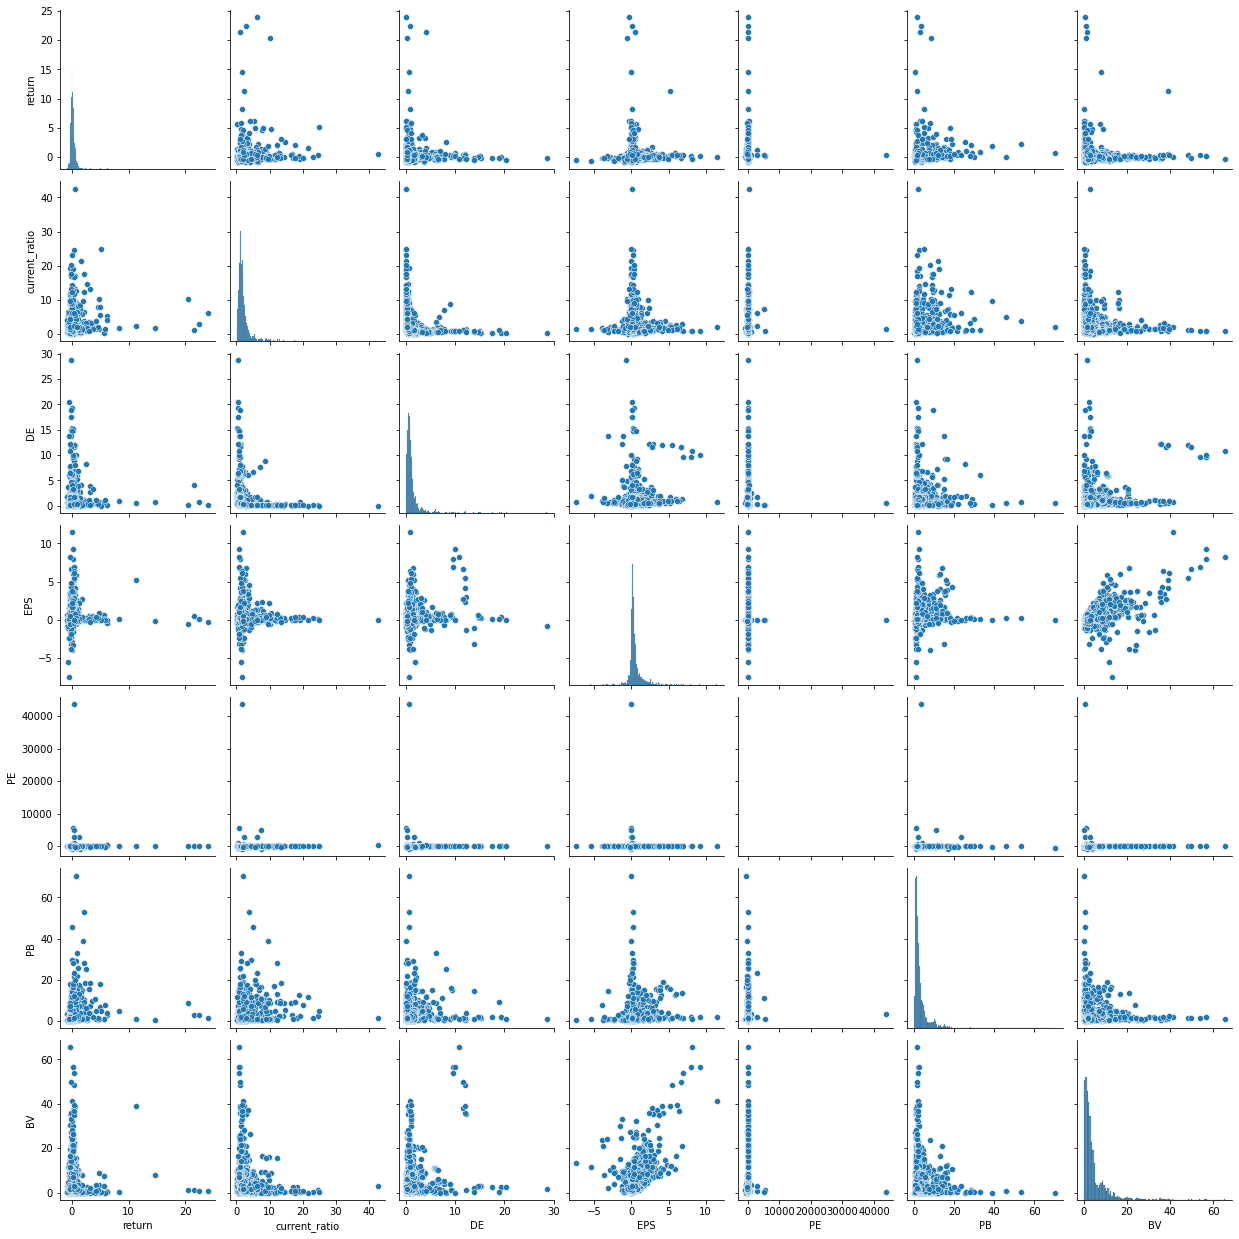

In [50]:
sns.pairplot(fin_asx200_clean[var_lists])

In [51]:
fin_asx200_clean.describe().T
# [['current_ratio','DE','EPS','PE','PB']]

,count,mean,std,min,25%,50%,75%,max
Year End Share Price ($),1654.0,1.155174e+01,2.066720e+01,1.000000e-02,2.450000e+00,5.050000e+00,1.210750e+01,2.870000e+02
Total Curr. Liabilities,1654.0,2.376627e+09,9.884148e+09,6.949100e+04,8.772300e+07,3.030090e+08,1.107033e+09,1.447210e+11
Total Current Assets,1654.0,2.508854e+09,9.327282e+09,2.069260e+05,1.606148e+08,4.747700e+08,1.560244e+09,1.279160e+11
Total Equity,1654.0,3.540613e+09,8.374705e+09,1.904347e+06,3.434893e+08,1.273649e+09,3.249598e+09,9.185547e+10
Total Liabilities,1654.0,5.807387e+09,1.895651e+10,6.949100e+04,2.379762e+08,8.806000e+08,3.379919e+09,2.340180e+11
Reported NPAT After Abnorma,1654.0,3.448381e+08,1.365478e+09,-8.358470e+09,2.641100e+07,1.027275e+08,2.956245e+08,2.229817e+10
Weighted Average Number of,1654.0,8.488611e+08,1.284959e+09,1.673340e+07,1.999795e+08,4.599943e+08,9.608678e+08,1.241800e+10
Market Cap.($),1654.0,7.108899e+09,1.811907e+10,7.766500e+05,9.978385e+08,2.338007e+09,6.622493e+09,2.331286e+11
current_ratio,1654.0,2.270506e+00,2.711765e+00,3.356424e-02,1.049724e+00,1.560866e+00,2.372651e+00,4.257083e+01
DE,1654.0,1.288083e+00,2.011384e+00,2.726586e-02,4.626982e-01,7.959298e-01,1.304093e+00,2.866734e+01


In [52]:
var_lists = ['return','current_ratio','DE','EPS','PE','PB']
var_lists_w1 = ['return_w1','current_ratio_w1','DE_w1','EPS_w1','PE_w1','PB_w1']
var_lists_w1_no_pe = ['return_w1','current_ratio_w1','DE_w1','EPS_w1','PB_w1']
var_transformed = ['return_w1_power','current_ratio_w1_power','DE_w1_power',
                   'EPS_w1_power','PE_w1_power','PB_w1_power']

# Summary statistics

In [53]:
# run all sample
# split the sample between +ve and -ve with t-tests

In [54]:
fin_asx200_clean[var_lists_w1].describe().T.to_csv('Table.csv')
fin_asx200_clean[var_lists_w1].describe().T

,count,mean,std,min,25%,50%,75%,max
return_w1,1654.0,0.222545,0.721520,-0.683333,-0.105498,0.073799,0.316561,4.818182
current_ratio_w1,1654.0,2.210395,2.257630,0.240938,1.049724,1.560866,2.372651,14.166672
DE_w1,1654.0,1.248872,1.696836,0.058968,0.462698,0.795930,1.304093,11.917912
EPS_w1,1654.0,0.477653,0.856789,-1.312463,0.081983,0.252915,0.569640,4.796474
PE_w1,1654.0,17.177063,42.314754,-175.892700,9.314326,16.372257,25.381585,229.993027
PB_w1,1654.0,3.250632,3.546851,0.390351,1.141662,1.917187,3.717045,18.754519


In [55]:
fin_asx200_clean.groupby(fin_asx200_clean.index)[var_lists_w1].describe().T.to_csv('Table.csv')
# fin_asx200_clean.groupby(fin_asx200_clean.index)[var_lists_w1].describe().T

In [56]:
fin_asx200_clean.loc[fin_asx200_clean['d_positive_ret']==True, var_lists_w1].describe().T.to_csv('Table.csv')
fin_asx200_clean.loc[fin_asx200_clean['d_positive_ret']==True, var_lists_w1].describe().T

,count,mean,std,min,25%,50%,75%,max
return_w1,1012.0,0.493684,0.802118,0.000000,0.105263,0.243322,0.542523,4.818182
current_ratio_w1,1012.0,2.265355,2.282907,0.240938,1.046926,1.592737,2.515122,14.166672
DE_w1,1012.0,1.180905,1.551688,0.058968,0.443313,0.764181,1.257877,11.917912
EPS_w1,1012.0,0.546148,0.872204,-1.312463,0.108833,0.270053,0.587107,4.796474
PE_w1,1012.0,20.265734,44.609238,-175.892700,10.901342,18.210965,27.358490,229.993027
PB_w1,1012.0,3.856773,3.984146,0.390351,1.326813,2.257239,4.635830,18.754519


In [57]:
fin_asx200_clean.loc[fin_asx200_clean['d_positive_ret']==False, var_lists_w1].describe().T.to_csv('Table.csv')
fin_asx200_clean.loc[fin_asx200_clean['d_positive_ret']==False, var_lists_w1].describe().T

,count,mean,std,min,25%,50%,75%,max
return_w1,642.0,-0.204858,0.169393,-0.683333,-0.299325,-0.158735,-0.070433,-0.000162
current_ratio_w1,642.0,2.123755,2.216196,0.240938,1.053368,1.515198,2.237692,14.166672
DE_w1,642.0,1.356006,1.899643,0.058968,0.493996,0.826280,1.363321,11.917912
EPS_w1,642.0,0.369682,0.821044,-1.312463,0.017626,0.221028,0.542214,4.796474
PE_w1,642.0,12.308314,37.946785,-175.892700,4.461695,13.575324,22.395861,229.993027
PB_w1,642.0,2.295169,2.431290,0.390351,0.935625,1.516193,2.565964,18.754519


# Correlation of all variables

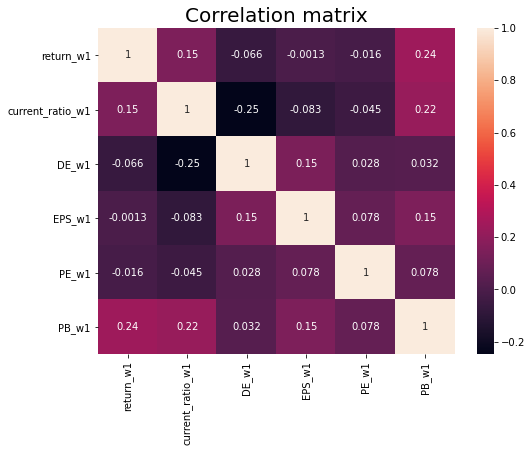

In [58]:
plt.figure(figsize=(8,6))
sns.heatmap(fin_asx200_clean[var_lists_w1].corr(), annot=True)
plt.title("Correlation matrix", size=20)
plt.savefig("correlation.png")

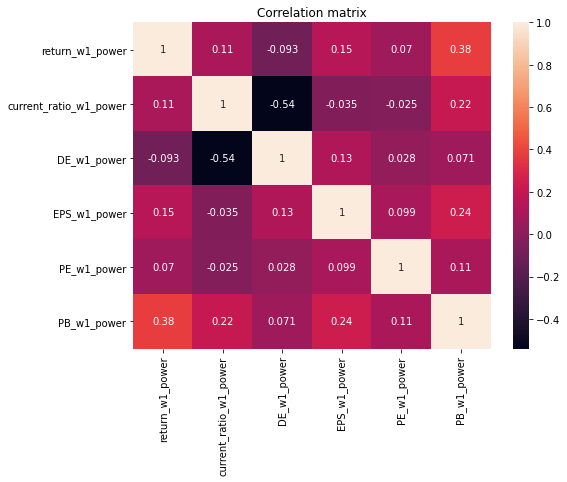

In [59]:
plt.figure(figsize=(8,6))
sns.heatmap(fin_asx200_clean[var_transformed].corr(), annot=True)
plt.title("Correlation matrix")
plt.savefig("correlation.png")

# Box/Bar plots for each variables

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe52daf1970>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe51c83f430>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe4f38345b0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fe51c847310>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe51c847eb0>,
 'means': []}

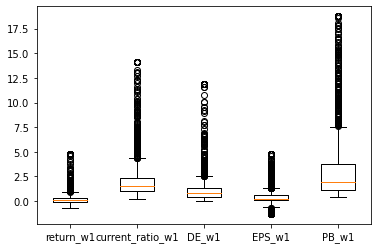

In [60]:
plt.boxplot(fin_asx200_clean[var_lists_w1_no_pe], 
            labels=var_lists_w1_no_pe)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe4f1de4880>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe4f1e30bb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe4f1de4550>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe4f1dc6640>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe4f1dc67c0>],
 'means': []}

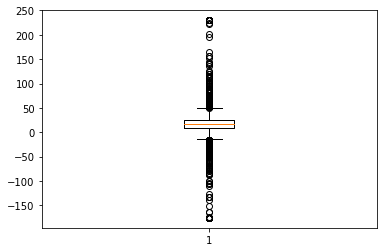

In [61]:
name = 'PE_w1'
plt.boxplot(fin_asx200_clean[name])

# Summary statistics

In [62]:
# run all sample
# split the sample between +ve and -ve with t-tests

# Box/Bar plots for each industry

(array([0, 1]), [Text(0, 0, 'False'), Text(1, 0, 'True')])

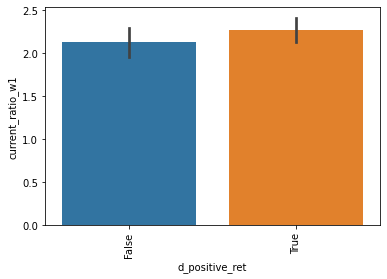

In [63]:
sns.barplot(x="d_positive_ret", y="current_ratio_w1", data=fin_asx200_clean)
plt.xticks(rotation=90)

(array([0, 1]), [Text(0, 0, 'False'), Text(1, 0, 'True')])

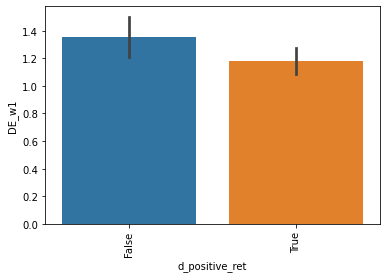

In [64]:
sns.barplot(x="d_positive_ret", y="DE_w1", data=fin_asx200_clean)
plt.xticks(rotation=90)

### key variables for each industry

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'Consumer Staples'),
  Text(1, 0, 'Materials'),
  Text(2, 0, 'Real Estate'),
  Text(3, 0, 'Utilities'),
  Text(4, 0, 'Consumer Discretionary'),
  Text(5, 0, 'Industrials'),
  Text(6, 0, 'Information Technology'),
  Text(7, 0, 'Financials'),
  Text(8, 0, 'Health Care'),
  Text(9, 0, 'Energy'),
  Text(10, 0, 'Communication Services')])

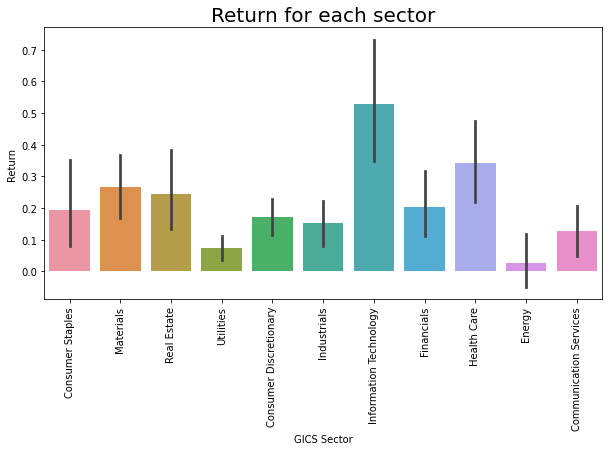

In [65]:
plt.figure(figsize=(10,5))
sns.barplot(x="GICS Sector", y="return_w1", data=fin_asx200_clean)
plt.title('Return for each sector', size=20)
plt.ylabel('Return')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'Consumer Staples'),
  Text(1, 0, 'Materials'),
  Text(2, 0, 'Real Estate'),
  Text(3, 0, 'Utilities'),
  Text(4, 0, 'Consumer Discretionary'),
  Text(5, 0, 'Industrials'),
  Text(6, 0, 'Information Technology'),
  Text(7, 0, 'Financials'),
  Text(8, 0, 'Health Care'),
  Text(9, 0, 'Energy'),
  Text(10, 0, 'Communication Services')])

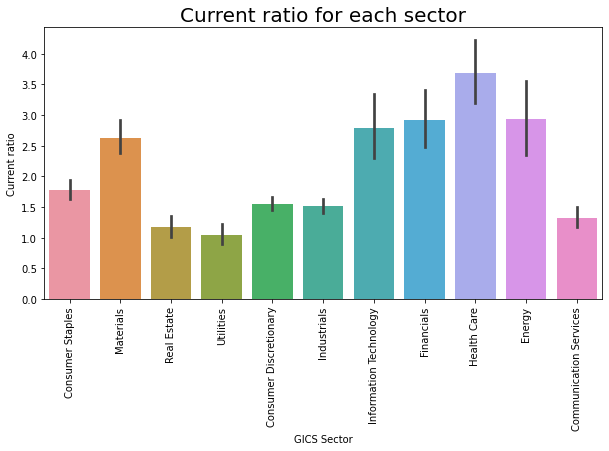

In [66]:
plt.figure(figsize=(10,5))
sns.barplot(x="GICS Sector", y="current_ratio_w1", data=fin_asx200_clean)
plt.title('Current ratio for each sector', size=20)
plt.ylabel('Current ratio')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'Consumer Staples'),
  Text(1, 0, 'Materials'),
  Text(2, 0, 'Real Estate'),
  Text(3, 0, 'Utilities'),
  Text(4, 0, 'Consumer Discretionary'),
  Text(5, 0, 'Industrials'),
  Text(6, 0, 'Information Technology'),
  Text(7, 0, 'Financials'),
  Text(8, 0, 'Health Care'),
  Text(9, 0, 'Energy'),
  Text(10, 0, 'Communication Services')])

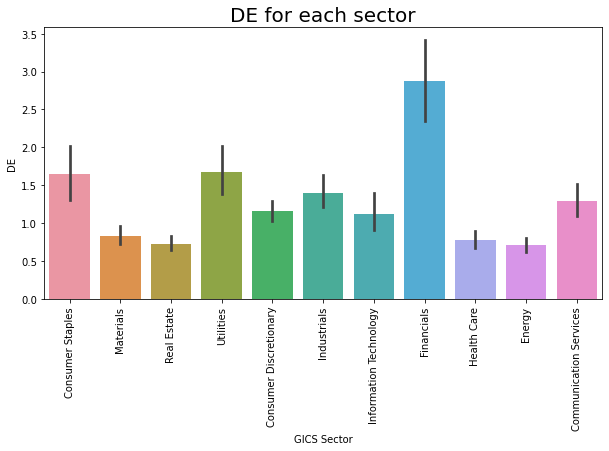

In [67]:
plt.figure(figsize=(10,5))
sns.barplot(x="GICS Sector", y="DE_w1", data=fin_asx200_clean)
plt.title('DE for each sector', size=20)
plt.ylabel('DE')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'Consumer Staples'),
  Text(1, 0, 'Materials'),
  Text(2, 0, 'Real Estate'),
  Text(3, 0, 'Utilities'),
  Text(4, 0, 'Consumer Discretionary'),
  Text(5, 0, 'Industrials'),
  Text(6, 0, 'Information Technology'),
  Text(7, 0, 'Financials'),
  Text(8, 0, 'Health Care'),
  Text(9, 0, 'Energy'),
  Text(10, 0, 'Communication Services')])

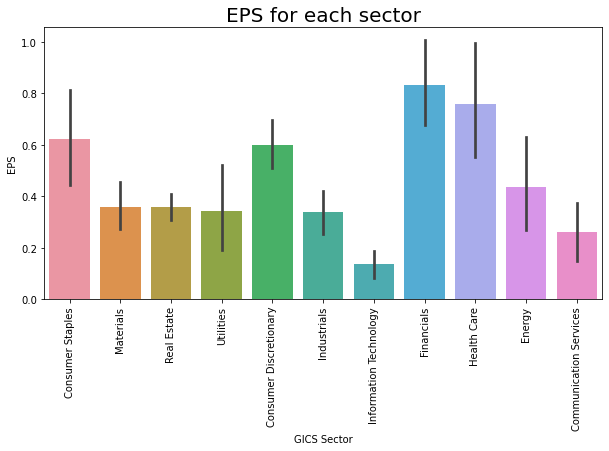

In [68]:
plt.figure(figsize=(10,5))
sns.barplot(x="GICS Sector", y="EPS_w1", data=fin_asx200_clean)
plt.title('EPS for each sector', size=20)
plt.ylabel('EPS')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'Consumer Staples'),
  Text(1, 0, 'Materials'),
  Text(2, 0, 'Real Estate'),
  Text(3, 0, 'Utilities'),
  Text(4, 0, 'Consumer Discretionary'),
  Text(5, 0, 'Industrials'),
  Text(6, 0, 'Information Technology'),
  Text(7, 0, 'Financials'),
  Text(8, 0, 'Health Care'),
  Text(9, 0, 'Energy'),
  Text(10, 0, 'Communication Services')])

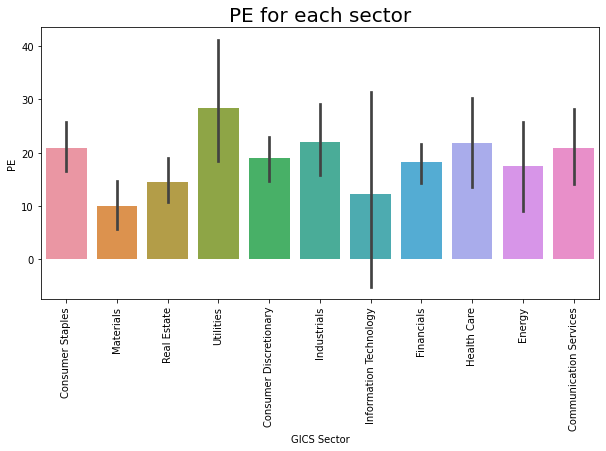

In [69]:
plt.figure(figsize=(10,5))
sns.barplot(x="GICS Sector", y="PE_w1", data=fin_asx200_clean)
plt.title('PE for each sector', size=20)
plt.ylabel('PE')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'Consumer Staples'),
  Text(1, 0, 'Materials'),
  Text(2, 0, 'Real Estate'),
  Text(3, 0, 'Utilities'),
  Text(4, 0, 'Consumer Discretionary'),
  Text(5, 0, 'Industrials'),
  Text(6, 0, 'Information Technology'),
  Text(7, 0, 'Financials'),
  Text(8, 0, 'Health Care'),
  Text(9, 0, 'Energy'),
  Text(10, 0, 'Communication Services')])

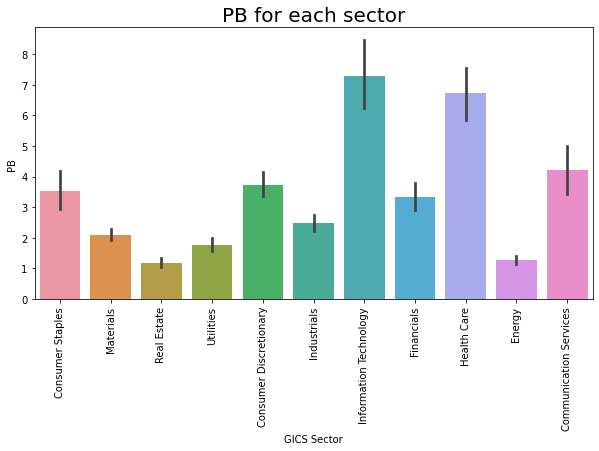

In [70]:
plt.figure(figsize=(10,5))
sns.barplot(x="GICS Sector", y="PB_w1", data=fin_asx200_clean)
plt.title('PB for each sector', size=20)
plt.ylabel('PB')
plt.xticks(rotation=90)

# Scatter plot

### Return vs current ratio

<AxesSubplot:xlabel='current_ratio_w1_power', ylabel='return_w1_power'>

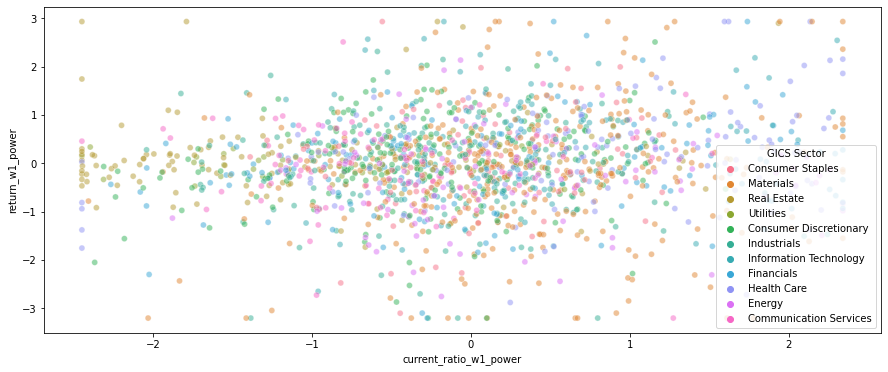

In [71]:
plt.figure(figsize=(15,6))
sns.scatterplot(data=fin_asx200_clean, x='current_ratio_w1_power', y='return_w1_power', hue='GICS Sector', alpha=0.5)


Text(0.5, 6.79999999999999, 'Current ratio')

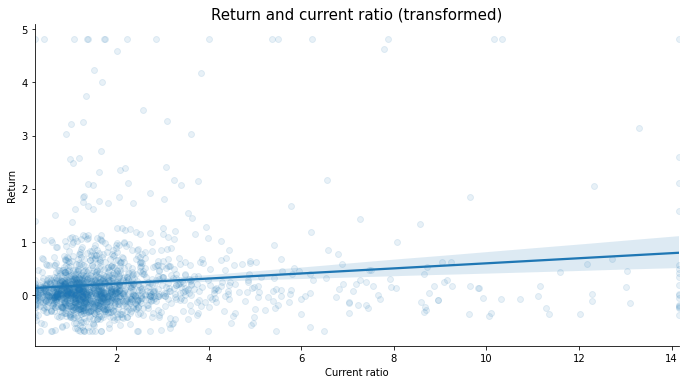

In [73]:
# plt.figure(figsize=(15,8))
g= sns.lmplot(data=fin_asx200_clean, x='current_ratio_w1', y='return_w1', scatter_kws={'alpha':0.1})
g.fig.set_size_inches(10,5)
plt.title("Return and current ratio (transformed)", size=15)
plt.ylabel('Return')
plt.xlabel('Current ratio')


### Return vs DE

<AxesSubplot:xlabel='DE_w1_power', ylabel='return_w1_power'>

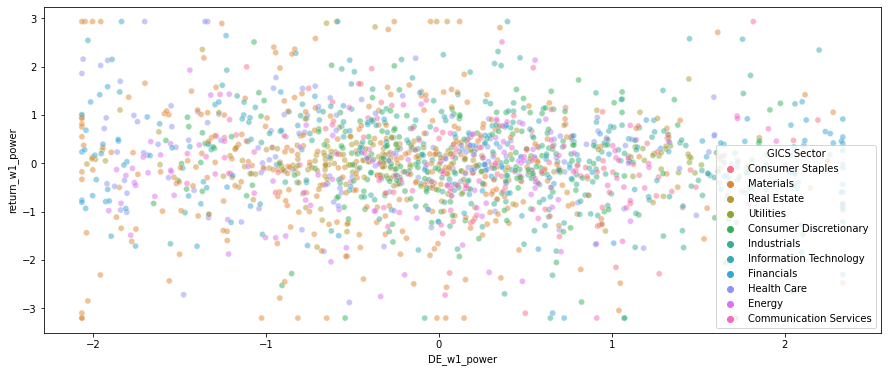

In [461]:
plt.figure(figsize=(15,6))
sns.scatterplot(data=fin_asx200_clean, x='DE_w1_power', y='return_w1_power', hue='GICS Sector', alpha=0.5)


Text(0.5, 6.79999999999999, 'DE')

<Figure size 1080x432 with 0 Axes>

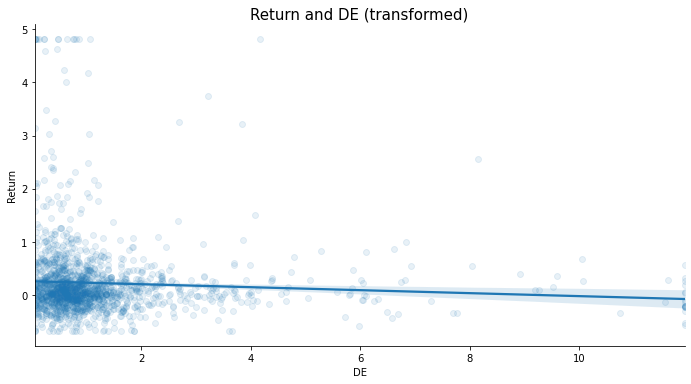

In [74]:
plt.figure(figsize=(15,6))
g=sns.lmplot(data=fin_asx200_clean, x='DE_w1', y='return_w1', scatter_kws={'alpha':0.1})
g.fig.set_size_inches(10,5)
plt.title("Return and DE (transformed)", size=15)
plt.ylabel('Return')
plt.xlabel('DE')

### Return vs EPS

<AxesSubplot:xlabel='EPS_w1_power', ylabel='return_w1_power'>

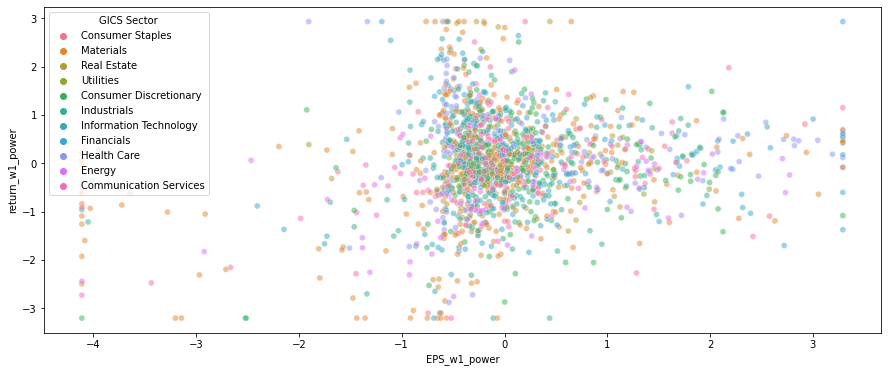

In [463]:
plt.figure(figsize=(15,6))
sns.scatterplot(data=fin_asx200_clean, x='EPS_w1_power', y='return_w1_power', hue='GICS Sector', alpha=0.5)


Text(0.5, 6.79999999999999, 'EPS')

<Figure size 1080x432 with 0 Axes>

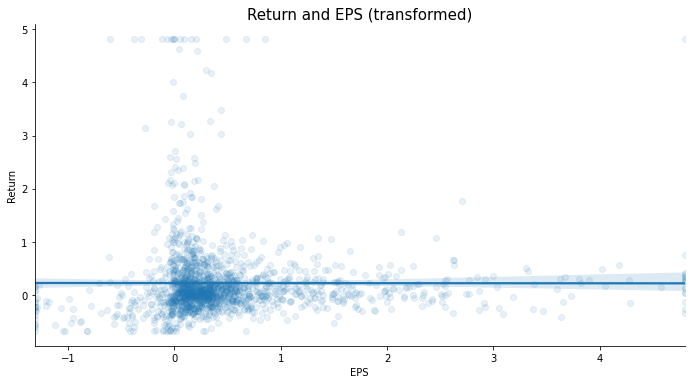

In [75]:
plt.figure(figsize=(15,6))
g=sns.lmplot(data=fin_asx200_clean, x='EPS_w1', y='return_w1', scatter_kws={'alpha':0.1})
g.fig.set_size_inches(10,5)
plt.title("Return and EPS (transformed)", size=15)
plt.ylabel('Return')
plt.xlabel('EPS')

### Return vs PE

<AxesSubplot:xlabel='PE_w1_power', ylabel='return_w1_power'>

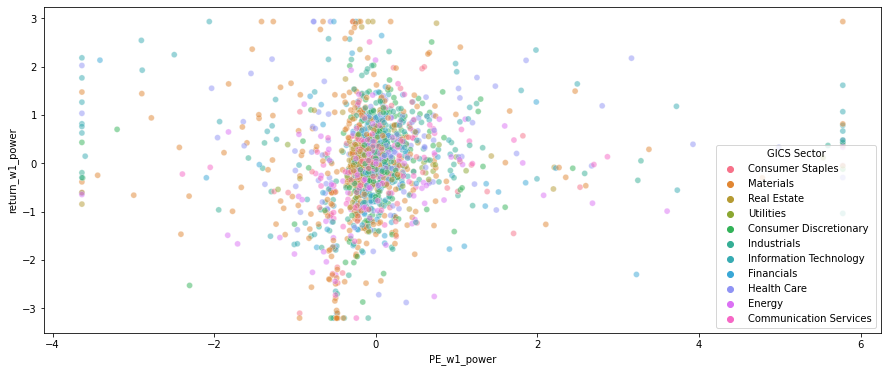

In [597]:
plt.figure(figsize=(15,6))
sns.scatterplot(data=fin_asx200_clean, x='PE_w1_power', y='return_w1_power', hue='GICS Sector', alpha=0.5)


Text(0.5, 6.79999999999999, 'PE')

<Figure size 1080x432 with 0 Axes>

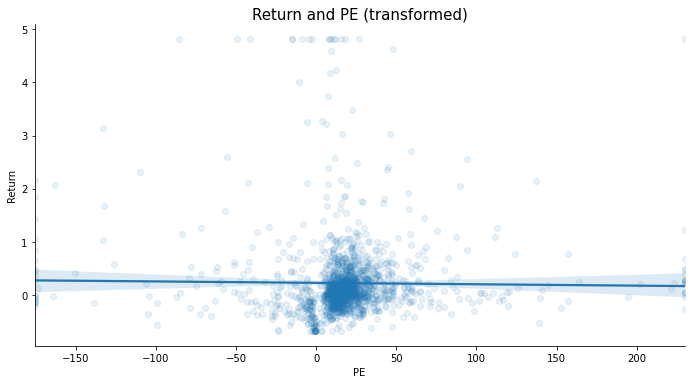

In [76]:
plt.figure(figsize=(15,6))
g=sns.lmplot(data=fin_asx200_clean, x='PE_w1', y='return_w1', scatter_kws={'alpha':0.1})
g.fig.set_size_inches(10,5)
plt.title("Return and PE (transformed)", size=15)
plt.ylabel('Return')
plt.xlabel('PE')

### Return vs PB

<AxesSubplot:xlabel='PB_w1_power', ylabel='return_w1_power'>

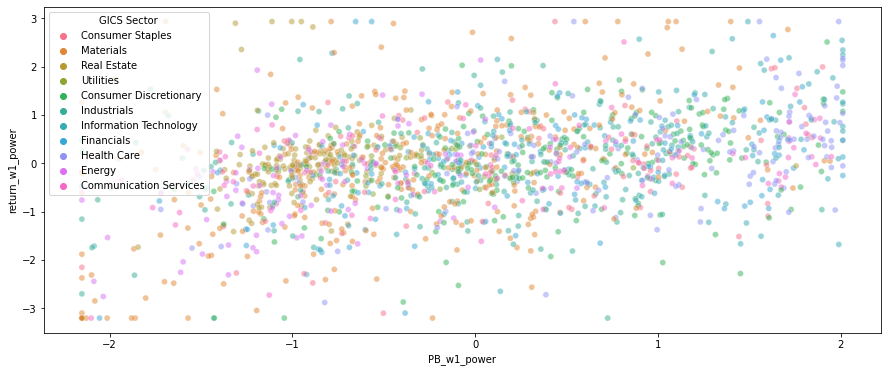

In [599]:
plt.figure(figsize=(15,6))
sns.scatterplot(data=fin_asx200_clean, x='PB_w1_power', y='return_w1_power', hue='GICS Sector', alpha=0.5)


Text(0.5, 6.79999999999999, 'PB')

<Figure size 1080x432 with 0 Axes>

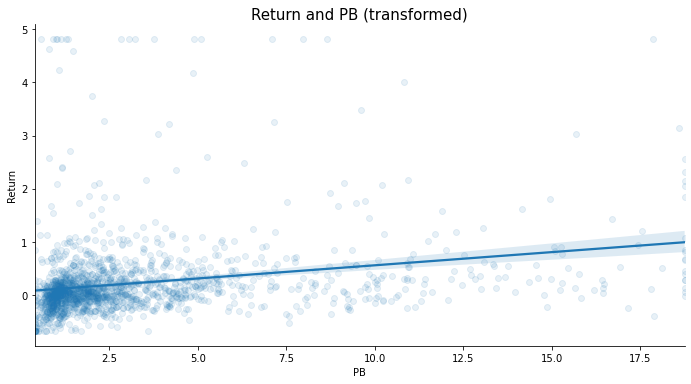

In [77]:
plt.figure(figsize=(15,6))
g=sns.lmplot(data=fin_asx200_clean, x='PB_w1', y='return_w1', scatter_kws={'alpha':0.1})
g.fig.set_size_inches(10,5)
plt.title("Return and PB (transformed)", size=15)
plt.ylabel('Return')
plt.xlabel('PB')

# comparison between positive and negative returns

In [62]:
positive_return = fin_asx200_clean.loc[fin_asx200_clean["d_positive_ret"]==True]
negative_return = fin_asx200_clean.loc[fin_asx200_clean["d_positive_ret"]==False]

In [493]:
# Firms with positive returns
positive_return[var_lists_w1].describe()

,return_w1,current_ratio_w1,DE_w1,EPS_w1,PE_w1,PB_w1
count,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000
mean,0.493684,2.265355,1.180905,0.546148,20.265734,3.856773
std,0.802118,2.282907,1.551688,0.872204,44.609238,3.984146
min,0.000000,0.240938,0.058968,-1.312463,-175.892700,0.390351
25%,0.105263,1.046926,0.443313,0.108833,10.901342,1.326813
50%,0.243322,1.592737,0.764181,0.270053,18.210965,2.257239
75%,0.542523,2.515122,1.257877,0.587107,27.358490,4.635830
max,4.818182,14.166672,11.917912,4.796474,229.993027,18.754519


In [709]:
# Firms with positive returns
negative_return[var_lists_w1].describe().T

,count,mean,std,min,25%,50%,75%,max
return_w1,642.0,-0.204858,0.169393,-0.683333,-0.299325,-0.158735,-0.070433,-0.000162
current_ratio_w1,642.0,2.123755,2.216196,0.240938,1.053368,1.515198,2.237692,14.166672
DE_w1,642.0,1.356006,1.899643,0.058968,0.493996,0.826280,1.363321,11.917912
EPS_w1,642.0,0.369682,0.821044,-1.312463,0.017626,0.221028,0.542214,4.796474
PE_w1,642.0,12.308314,37.946785,-175.892700,4.461695,13.575324,22.395861,229.993027
PB_w1,642.0,2.295169,2.431290,0.390351,0.935625,1.516193,2.565964,18.754519


/Users/jinyang/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jinyang/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


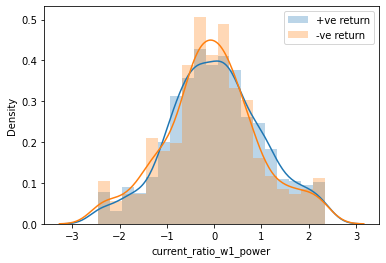

In [548]:
sns.distplot(positive_return['current_ratio_w1_power'], hist=True, kde=True, label='+ve return', hist_kws={'alpha': 0.3})
sns.distplot(negative_return['current_ratio_w1_power'], hist=True, kde=True, label='-ve return', hist_kws={'alpha': 0.3})
plt.legend()

/Users/jinyang/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jinyang/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


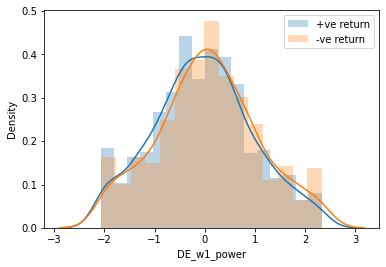

In [550]:
sns.distplot(positive_return['DE_w1_power'], hist=True, kde=True, label='+ve return', hist_kws={'alpha': 0.3})
sns.distplot(negative_return['DE_w1_power'], hist=True, kde=True, label='-ve return', hist_kws={'alpha': 0.3})
plt.legend()

/Users/jinyang/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jinyang/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


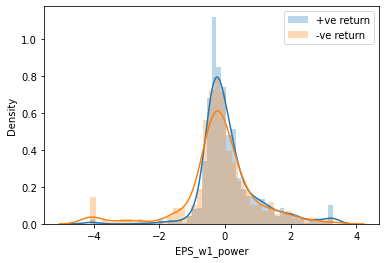

In [551]:
sns.distplot(positive_return['EPS_w1_power'], hist=True, kde=True, label='+ve return', hist_kws={'alpha': 0.3})
sns.distplot(negative_return['EPS_w1_power'], hist=True, kde=True, label='-ve return', hist_kws={'alpha': 0.3})
plt.legend()

/Users/jinyang/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jinyang/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


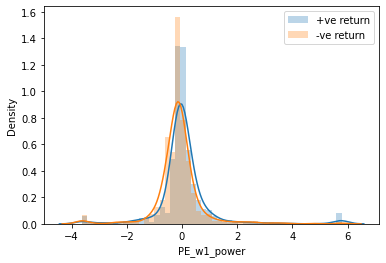

In [552]:
sns.distplot(positive_return['PE_w1_power'], hist=True, kde=True, label='+ve return', hist_kws={'alpha': 0.3})
sns.distplot(negative_return['PE_w1_power'], hist=True, kde=True, label='-ve return', hist_kws={'alpha': 0.3})
plt.legend()

/Users/jinyang/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jinyang/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


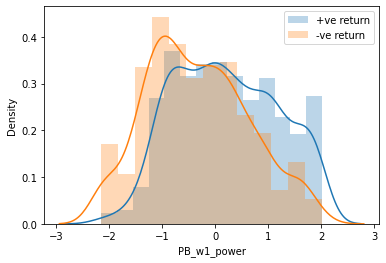

In [553]:
sns.distplot(positive_return['PB_w1_power'], hist=True, kde=True, label='+ve return', hist_kws={'alpha': 0.3})
sns.distplot(negative_return['PB_w1_power'], hist=True, kde=True, label='-ve return', hist_kws={'alpha': 0.3})
plt.legend()

# Plot for postive vs negative (for appendix 2)

### changes in mean over the period

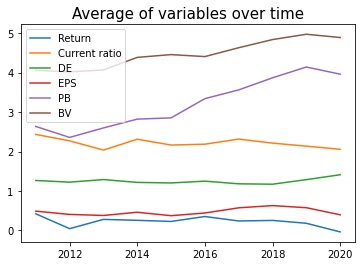

In [39]:
plt.plot(mean_return, label="Return")
plt.plot(mean_current_ratio, label="Current ratio")
plt.plot(mean_DE, label="DE")
plt.plot(mean_EPS, label="EPS")
# plt.plot(mean_PE, label="PE")
plt.plot(mean_PB, label="PB")
plt.plot(mean_BV, label="BV")

plt.title("Average of variables over time", size=15)
plt.legend()

### Current ratio

Text(0.5, 1.0, 'Current ratio - positive vs negative return')

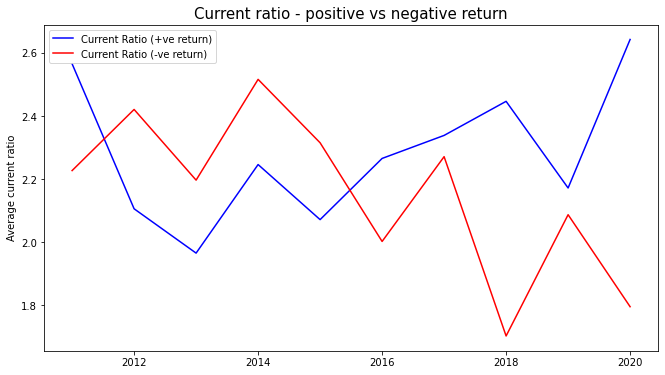

In [64]:
plt.figure(figsize=(11,6))
plt.plot(positive_return.groupby('year')['current_ratio_w1'].mean(), label="Current Ratio (+ve return)", color='blue')
plt.plot(negative_return.groupby('year')['current_ratio_w1'].mean(), label="Current Ratio (-ve return)", color='red')
plt.legend()
plt.ylabel("Average current ratio")
plt.title("Current ratio - positive vs negative return", size=15)

### DE ratio

Text(0.5, 1.0, 'DE - positive vs negative return')

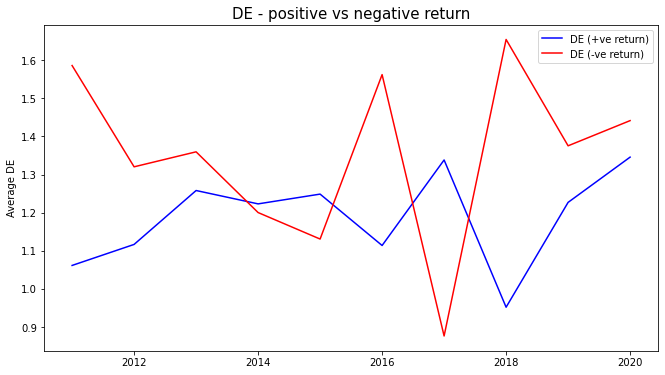

In [65]:
plt.figure(figsize=(11,6))
plt.plot(positive_return.groupby('year')['DE_w1'].mean(), label="DE (+ve return)", color='blue')
plt.plot(negative_return.groupby('year')['DE_w1'].mean(), label="DE (-ve return)", color='red')
plt.legend()
plt.ylabel("Average DE")
plt.title("DE - positive vs negative return", size=15)

### EPS ratio

Text(0.5, 1.0, 'EPS - positive vs negative return')

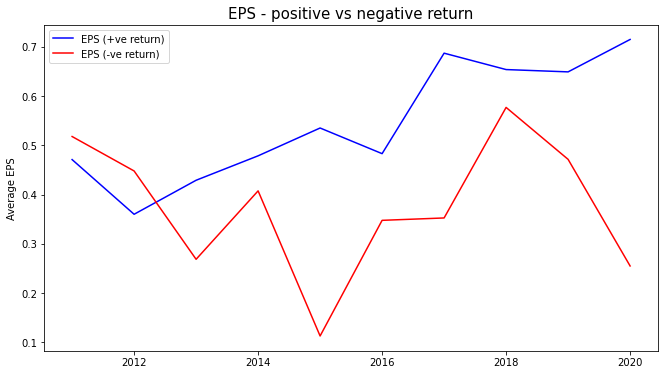

In [66]:
plt.figure(figsize=(11,6))
plt.plot(positive_return.groupby('year')['EPS_w1'].mean(), label="EPS (+ve return)", color='blue')
plt.plot(negative_return.groupby('year')['EPS_w1'].mean(), label="EPS (-ve return)", color='red')
plt.legend()
plt.ylabel("Average EPS")
plt.title("EPS - positive vs negative return", size=15)

### PE ratio

Text(0.5, 1.0, 'PE - positive vs negative return')

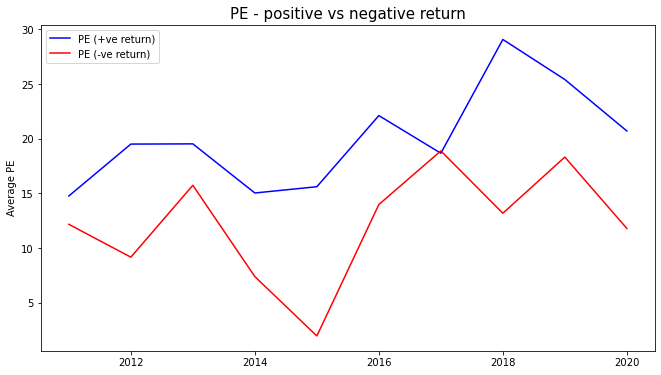

In [67]:
plt.figure(figsize=(11,6))
plt.plot(positive_return.groupby('year')['PE_w1'].mean(), label="PE (+ve return)", color='blue')
plt.plot(negative_return.groupby('year')['PE_w1'].mean(), label="PE (-ve return)", color='red')
plt.legend()
plt.ylabel("Average PE")
plt.title("PE - positive vs negative return", size=15)

### PB ratio

Text(0.5, 1.0, 'PB - positive vs negative return')

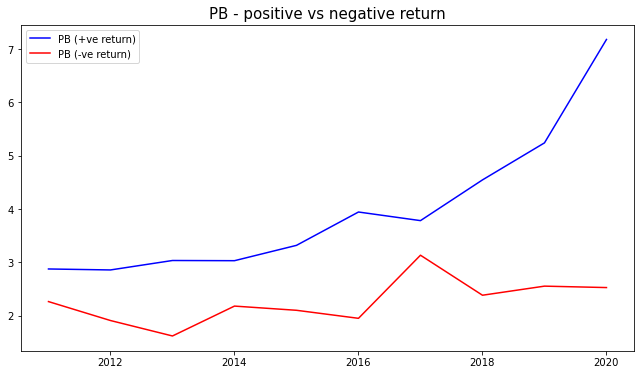

In [68]:
plt.figure(figsize=(11,6))
plt.plot(positive_return.groupby('year')['PB_w1'].mean(), label="PB (+ve return)", color='blue')
plt.plot(negative_return.groupby('year')['PB_w1'].mean(), label="PB (-ve return)", color='red')
plt.legend()
plt.title("PB - positive vs negative return", size=15)

# T-test between +ve vs -ve returns

In [726]:
# using sample
N = 500
sample_positive_return = positive_return #.sample(n=N)
sample_negative_return = negative_return #.sample(n=N)

/Users/jinyang/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jinyang/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


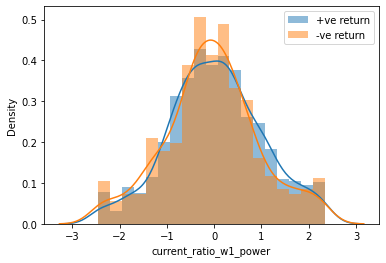

In [718]:
sns.distplot(sample_positive_return['current_ratio_w1_power'], hist=True, kde=True, label='+ve return', hist_kws={'alpha': 0.5})
sns.distplot(sample_negative_return['current_ratio_w1_power'], hist=True, kde=True, label='-ve return', hist_kws={'alpha': 0.5})
plt.legend()

In [556]:
# ANSWER
def ttest_func(a, b, alpha=0.05):
    N = len(a)
    
    # variance
    a_var = a.var()
    b_var = b.var()
    print(f'{a} variance: {a_var}')
    print(f'{b} variance: {b_var}')
    
    # Caculate the Standard Deviation
    std = np.sqrt((a_var + b_var)/2)
    print('std dev: ', std)
    
    tstat = ((a.mean() - b.mean())/(std*np.sqrt(2/N)))
    print(tstat)
    
    df = 2*N -2
    print(df)

    p = 1 - stats.t.cdf(tstat,df=df)
    print(p)
    print(str(abs(p/2)))


def print_sig(p_value, alpha):
    if p_value < alpha: 
        print("We reject our null hypothesis.")
        
    elif p_value > alpha: 
        print("We fail to reject our null hypothesis.")
        
    else: 
        print("Our test is inconclusive")


In [741]:
# current_ratio_w1_power
test_var = 'current_ratio_w1'
alpha = 0.05
t2, p2 = stats.ttest_ind(sample_positive_return[test_var],sample_negative_return[test_var])
print("t-stat = " + str(t2))
print("p_value = " + str(p2))
print_sig(p2, alpha)

t-stat = 1.834818116653752
p_value = 0.06671236559247587
We fail to reject our null hypothesis.


In [728]:
# DE_w1
test_var = 'DE_w1'
alpha = 0.05
t2, p2 = stats.ttest_ind(sample_positive_return[test_var],sample_negative_return[test_var])
print("t-stat = " + str(t2))
print("p_value = " + str(p2))
print_sig(p2, alpha)

t-stat = -2.0471627533026573
p_value = 0.040800006991317854
We reject our null hypothesis.


In [729]:
# EPS_w1
test_var = 'EPS_w1'
alpha = 0.05
t2, p2 = stats.ttest_ind(sample_positive_return[test_var],sample_negative_return[test_var])
print("t-stat = " + str(t2))
print("p_value = " + str(p2))
print_sig(p2, alpha)

t-stat = 4.101529606090686
p_value = 4.303947550639275e-05
We reject our null hypothesis.


In [730]:
# PE_w1
test_var = 'PE_w1'
alpha = 0.05
t2, p2 = stats.ttest_ind(sample_positive_return[test_var],sample_negative_return[test_var])
print("t-stat = " + str(t2))
print("p_value = " + str(p2))
print_sig(p2, alpha)

t-stat = 3.741727460594029
p_value = 0.0001890087749439209
We reject our null hypothesis.


In [731]:
# PB_w1
test_var = 'PB_w1'
alpha = 0.05
t2, p2 = stats.ttest_ind(sample_positive_return[test_var],sample_negative_return[test_var])
print("t-stat = " + str(t2))
print("p_value = " + str(p2))
print_sig(p2, alpha)

t-stat = 8.931534171256203
p_value = 1.0934900417545869e-18
We reject our null hypothesis.


In [715]:
positive_return[var_lists_w1].describe().T.to_csv('Table.csv')
positive_return[var_lists_w1].describe().T

,count,mean,std,min,25%,50%,75%,max
return_w1,1012.0,0.493684,0.802118,0.000000,0.105263,0.243322,0.542523,4.818182
current_ratio_w1,1012.0,2.265355,2.282907,0.240938,1.046926,1.592737,2.515122,14.166672
DE_w1,1012.0,1.180905,1.551688,0.058968,0.443313,0.764181,1.257877,11.917912
EPS_w1,1012.0,0.546148,0.872204,-1.312463,0.108833,0.270053,0.587107,4.796474
PE_w1,1012.0,20.265734,44.609238,-175.892700,10.901342,18.210965,27.358490,229.993027
PB_w1,1012.0,3.856773,3.984146,0.390351,1.326813,2.257239,4.635830,18.754519


In [716]:
negative_return[var_lists_w1].describe().T.to_csv('Table.csv')
negative_return[var_lists_w1].describe().T

,count,mean,std,min,25%,50%,75%,max
return_w1,642.0,-0.204858,0.169393,-0.683333,-0.299325,-0.158735,-0.070433,-0.000162
current_ratio_w1,642.0,2.123755,2.216196,0.240938,1.053368,1.515198,2.237692,14.166672
DE_w1,642.0,1.356006,1.899643,0.058968,0.493996,0.826280,1.363321,11.917912
EPS_w1,642.0,0.369682,0.821044,-1.312463,0.017626,0.221028,0.542214,4.796474
PE_w1,642.0,12.308314,37.946785,-175.892700,4.461695,13.575324,22.395861,229.993027
PB_w1,642.0,2.295169,2.431290,0.390351,0.935625,1.516193,2.565964,18.754519


# Regression (Linear? OLS?)

# Visualisation

In [ ]:
fin_asx200_clean['current_ratio']
fin_asx200_clean['DE']
fin_asx200_clean['EPS']
fin_asx200_clean['EPS_3yr']
fin_asx200_clean['PE']
fin_asx200_clean['PB']

In [633]:
firm_2015_lists = ['EVN', 'OZL', 'SAR', 'SGM', 'SSM']

# Stock price from yahoo finance

In [655]:
start = '2015-01-01'
end = date.today()

In [656]:
XJO = web.DataReader('^AXJO', 'yahoo',start,end)
ORD = web.DataReader('^AORD', 'yahoo',start,end)

STW = web.DataReader('STW.AX','yahoo',start,end)
# 2012
COE = web.DataReader('COE.AX','yahoo',start,end)
# 2013
ORE = web.DataReader('ORE.AX','yahoo',start,end)
PMV = web.DataReader('PMV.AX','yahoo',start,end)
# 2014
IGO = web.DataReader('IGO.AX','yahoo',start,end)
SGM = web.DataReader('SGM.AX','yahoo',start,end)
# 2015
EVN = web.DataReader('EVN.AX','yahoo',start,end)
OZL = web.DataReader('OZL.AX','yahoo',start,end)
SAR = web.DataReader('SAR.AX','yahoo',start,end)
SGM = web.DataReader('SGM.AX','yahoo',start,end)
SSM = web.DataReader('SSM.AX','yahoo',start,end)
# 2016
SLR = web.DataReader('SLR.AX','yahoo',start,end)
# 2017
BKW = web.DataReader('BKW.AX','yahoo',start,end)
BPT = web.DataReader('BPT.AX','yahoo',start,end)
JHG = web.DataReader('JHG.AX','yahoo',start,end)
S32 = web.DataReader('S32.AX','yahoo',start,end)
SOL = web.DataReader('SOL.AX','yahoo',start,end)
# 2018
WPL = web.DataReader('WPL.AX','yahoo',start,end)



In [577]:
STW.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2011-01-03,44.970001,44.439999,44.970001,44.700001,200984.0,44.700001
2011-01-04,44.650002,44.200001,44.599998,44.340000,151753.0,44.340000
2011-01-05,44.480000,44.139999,44.480000,44.400002,182812.0,44.400002
2011-01-06,44.349998,44.090000,44.299999,44.250000,140878.0,44.250000
2011-01-09,44.310001,44.029999,44.139999,44.310001,210607.0,44.310001


<Figure size 1080x576 with 0 Axes>

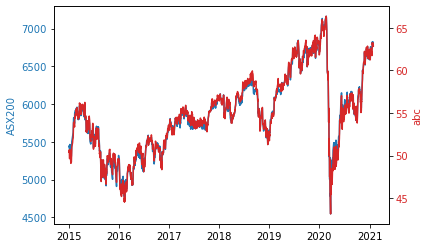

In [54]:
plt.figure(figsize=(15,8))
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.plot('Close', data=XJO, color=color, label='ASX200')
ax1.set_ylabel('ASX200', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot('Close', data=STW, color=color, label='abc')
ax2.set_ylabel('abc', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# plt.plot(XJO['Close'], label='ASX200')
# plt.plot(STW['Close'], label='STW')
# plt.legend()

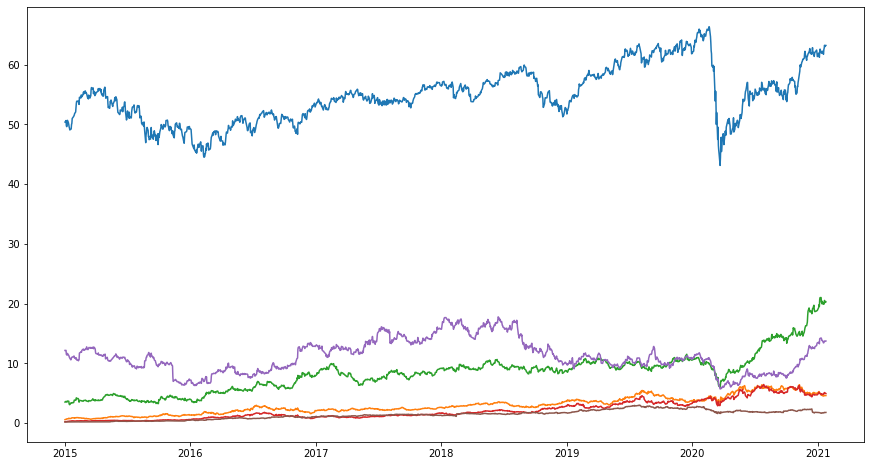

In [612]:
plt.figure(figsize=(15,8))
plt.plot(STW['Close'])
plt.plot(EVN['Close'])
plt.plot(OZL['Close'])
plt.plot(SAR['Close'])
plt.plot(SGM['Close'])
plt.plot(SSM['Close'])


In [657]:
# Daily percentage change
# cumulative returns
for df in (XJO, STW, COE, ORE, PMV, IGO, SGM, EVN, OZL, SAR, SGM, SSM, SLR, BKW, BPT, JHG, S32, SOL, WPL):
    
    # Daily percentage change
    df['returns'] = (df['Close']/df['Close'].shift(1))-1
    
    # cumulative returns
    df['cumulative return'] = (1 + df['returns']).cumprod()
    
     
# net returns minus ASX200 returns
for df in (COE, ORE, PMV, IGO, SGM, EVN, OZL, SAR, SGM, SSM, SLR, BKW, BPT, JHG, S32, SOL, WPL):
    # net returns
    df['net_returns'] = (df['returns']-XJO['returns'])

# COE['returns'] = (COE['Close']/COE['Close'].shift(1))-1
# ORE['returns'] = (ORE['Close']/ORE['Close'].shift(1))-1
# PMV['returns'] = (PMV['Close']/PMV['Close'].shift(1))-1
# IGO['returns'] = (IGO['Close']/IGO['Close'].shift(1))-1
# SGM['returns'] = (SGM['Close']/SGM['Close'].shift(1))-1

# EVN['returns'] = (EVN['Close']/EVN['Close'].shift(1))-1
# OZL['returns'] = (OZL['Close']/OZL['Close'].shift(1))-1
# SAR['returns'] = (SAR['Close']/SAR['Close'].shift(1))-1
# SGM['returns'] = (SGM['Close']/SGM['Close'].shift(1))-1
# SSM['returns'] = (SSM['Close']/SSM['Close'].shift(1))-1


In [668]:
selected_firms_lists

{'year2012': ['COE'],
 'year2013': ['ORE', 'PMV'],
 'year2014': ['IGO', 'SGM'],
 'year2015': ['EVN', 'OZL', 'SAR', 'SGM', 'SSM'],
 'year2016': ['SLR'],
 'year2017': ['BKW', 'BPT', 'JHG', 'S32', 'SOL'],
 'year2018': ['WPL']}

In [659]:
# 2012
equal_port_cum_ret_2012 = (COE['cumulative return'])
# 2013
equal_port_cum_ret_2013 = (ORE['cumulative return']+PMV['cumulative return'])/2
# 2014
equal_port_cum_ret_2014 = (IGO['cumulative return']+SGM['cumulative return'])/2
# 2015
equal_port_cum_ret_2015 = (EVN['cumulative return']+OZL['cumulative return']+SAR['cumulative return']+SGM['cumulative return']+SSM['cumulative return'])/5
equal_port_net_ret_2015 = (EVN['net_returns']+OZL['net_returns']+SAR['net_returns']+SGM['net_returns']+SSM['net_returns'])/5

# 2016
equal_port_cum_ret_2016 = (SLR['cumulative return'])
# 2017
equal_port_cum_ret_2017 = (BKW['cumulative return']+BPT['cumulative return']+JHG['cumulative return']+S32['cumulative return']+SOL['cumulative return'])/5
# 2018
equal_port_cum_ret_2018 = (WPL['cumulative return'])


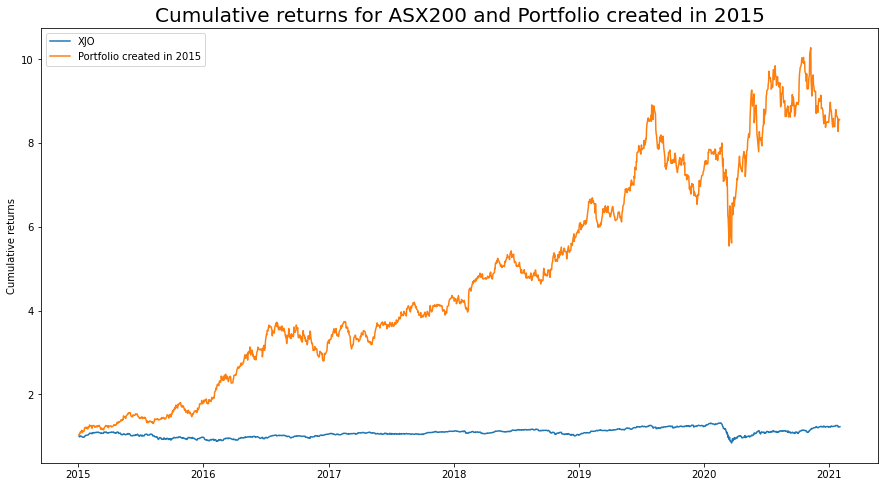

In [737]:
plt.figure(figsize=(15,8))
plt.plot(XJO['cumulative return'], label='XJO')
# plt.plot(STW['cumulative return'], label='STW')
# plt.plot(equal_port_cum_ret_2012, label='2012')
# plt.plot(equal_port_cum_ret_2013, label='2013')
# plt.plot(equal_port_cum_ret_2014, label='2014')
plt.plot(equal_port_cum_ret_2015, label='Portfolio created in 2015')
# plt.plot(equal_port_cum_ret_2016, label='2016')
# plt.plot(equal_port_cum_ret_2017, label='2017')
# plt.plot(equal_port_cum_ret_2018, label='2018')

plt.title("Cumulative returns for ASX200 and Portfolio created in 2015", size=20)
plt.ylabel("Cumulative returns")
plt.legend()


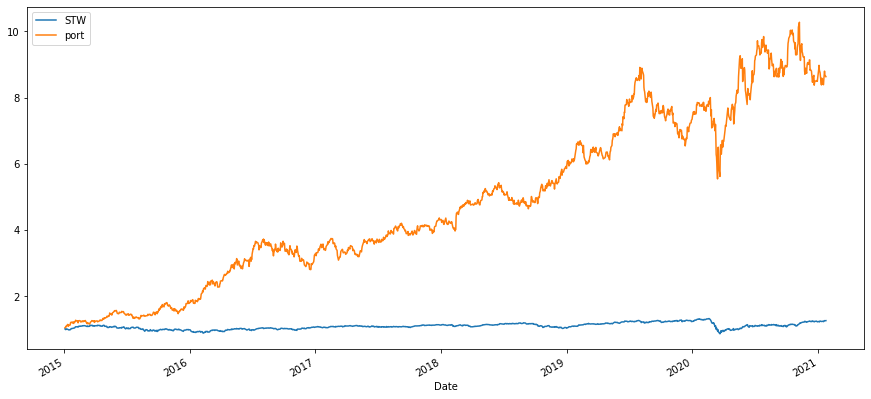

In [655]:
STW['cumulative return'].plot(label='STW', figsize=(15,7))
# Eequal_port_cum_ret_2015cumulative return'].plot(label='SSM')
equal_port_cum_ret_2015.plot(label='port')

plt.legend()


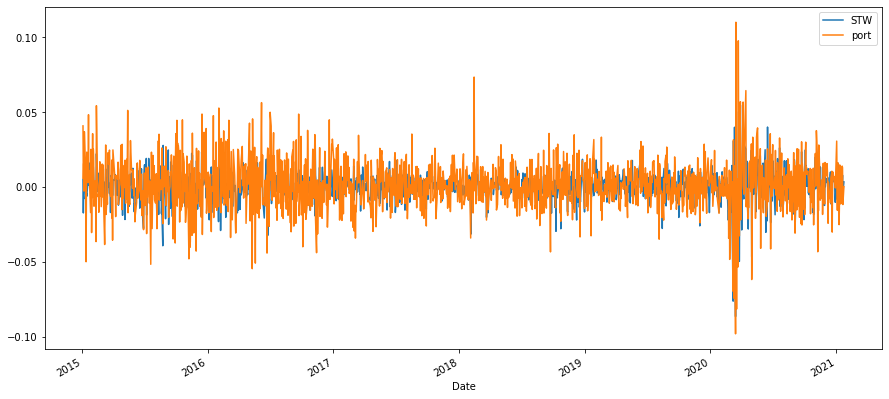

In [618]:
STW['returns'].plot(label='STW', figsize=(15,7))
# Eequal_port_cum_ret_2015cumulative return'].plot(label='SSM')
equal_port_ret_2015.plot(label='port')

plt.legend()


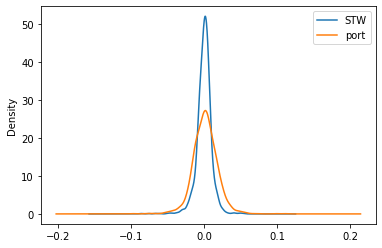

In [619]:
STW['returns'].plot(kind='kde', label='STW')
equal_port_ret_2015.plot(kind='kde', label='port')
plt.legend()

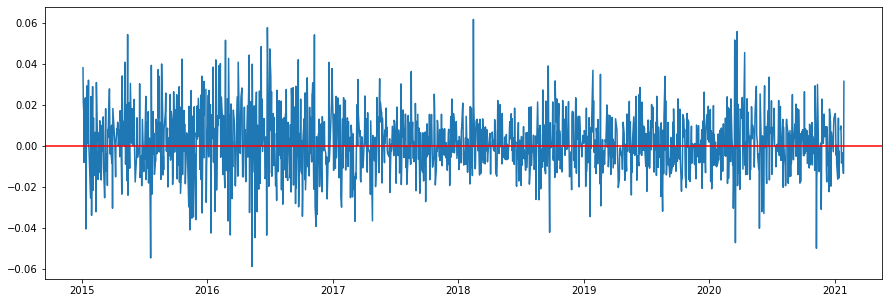

In [668]:
plt.figure(figsize=(15,5))
plt.plot(equal_port_net_ret_2015)
plt.axhline(y=0, color='red')

In [653]:
COE.index

DatetimeIndex(['2011-01-03', '2011-01-04', '2011-01-05', '2011-01-06',
               '2011-01-09', '2011-01-10', '2011-01-11', '2011-01-12',
               '2011-01-13', '2011-01-16',
               ...
               '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20',
               '2021-01-21', '2021-01-24', '2021-01-26', '2021-01-27',
               '2021-01-28', '2021-02-01'],
              dtype='datetime64[ns]', name='Date', length=2548, freq=None)